# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def print_full(x):
    """
    helper function for printing an entire dataframe (non-truncated version)
    source: https://stackoverflow.com/questions/25351968/how-can-i-display-full-non-truncated-dataframe-information-in-html-when-conver
    """
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.6f}'.format)
    pd.set_option('display.max_colwidth', None)
    return x
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

# Load csv file


#### Multiple regularisation hyperparameters

In [3]:
# mini batch setting
df_main = pd.read_csv('multi_higher_minibatch_gradcliprescaling_nations.csv') # both with and without rescaling
# df_main = df_main[df_main["regweight_rescaler"]==1.05] # with rescaling
# df_main = df_main[df_main["regweight_rescaler"]!=1.05] # without rescaling
df_main['regweight_init'] = df_main['init_size_lmbda']

df_main["delta_dev_is_negative"] = np.sign(df_main["final_delta_outer_dev_loss"])<0

In [16]:
# full batch setting
df_temp = pd.read_csv('multi_higher_fullbatch_gradcliprescaling_nations.csv') # combined with and without rescaling
df_temp['regweight_rescaler'].fillna(value=1.0, inplace=True)
df_temp['grad_clip_val_outer'].fillna(value=99999999999.0, inplace=True)
df_temp['regweight_init'] = df_temp['init_size_lmbda']

# df_main = df_temp[df_temp["regweight_rescaler"]==1.05] # with rescaling
# df_main = df_temp[df_temp["regweight_rescaler"]!=1.05] # without rescaling
df_main = df_temp # both with and without rescaling

df_main["delta_dev_is_negative"] = np.sign(df_main["final_delta_outer_dev_loss"])<0

#### Single regularisation hyperparameter

Top cell = minibatch |
Bottom cell = full batch

In [4]:
# mini batch setting
df_main = pd.read_csv('single_higher_minibatch_gradcliprescaling_nations.csv') # both with and without rescaling
df_main = df_main[df_main["regweight_rescaler"]==1.05] # with rescaling
# df_main = df_main[df_main["regweight_rescaler"]!=1.05] # without rescaling

df_main["delta_dev_is_negative"] = np.sign(df_main["final_delta_outer_dev_loss"])<0

In [2]:
# full batch setting
df_temp = pd.read_csv('single_higher_fullbatch_gradcliprescaling_nations.csv') # combined with and without rescaling
df_temp['regweight_rescaler'].fillna(value=1.0, inplace=True)
df_temp['grad_clip_val_outer'].fillna(value=99999999999.0, inplace=True)

df_main = df_temp[df_temp["regweight_rescaler"]==1.05] # with rescaling
# df_main = df_temp[df_temp["regweight_rescaler"]!=1.05] # without rescaling
df_main = df_temp # both with and without rescaling

df_main["delta_dev_is_negative"] = np.sign(df_main["final_delta_outer_dev_loss"])<0

#### Evolutionary strategy, single regularisation hyperparameter, fullbatch

In [3]:
# full batch setting
df_temp = pd.read_csv('single_es_fullbatch_gradclip_nations.csv')
df_temp['regweight_rescaler'].fillna(value=1.0, inplace=True)
df_temp['grad_clip_val_outer'].fillna(value=99999999999.0, inplace=True)

df_main = df_temp

df_main["delta_dev_is_negative"] = np.sign(df_main["final_delta_outer_dev_loss"])<0

#### Display other hyperparameter values used in sweep

In [5]:
# Display included values of important hyperparameters

clip_val_list = list(df_main['grad_clip_val_outer'].unique())
regweight_list = list(df_main['regweight_init'].unique())
rescale_list = list(df_main['regweight_rescaler'].unique())
epochs_list = list(df_main["epochs"].unique())

print(f"Hypergradient clipping values: {clip_val_list}")
print(f"Regularisation weight initialisation values: {regweight_list}")
print(f"Auto-rescaling values: {rescale_list}")
print(f"Numbers of epochs (inner steps): {epochs_list}")

Hypergradient clipping values: [99999999999.0, 0.5]
Regularisation weight initialisation values: [0.015]
Auto-rescaling values: [1.05]
Numbers of epochs (inner steps): [30, 20, 15, 10, 7, 5, 3, 2, 1]


# Exploring overall results

In [5]:
# BASELINE RESULTS (GRID SEARCH)

# df_main_grid = pd.read_csv('single_grid_minibatch_gradcliprescaling_nations_v2.csv') # UNCOMMENT FOR MINIBATCH
df_main_grid = pd.read_csv('single_grid_fullbatch_gradcliprescaling_nations.csv') # UNCOMMENT FOR FULL BATCH
df_main_grid = df_main_grid.round({"regweight_init": 6})
epochs_list_grid = list(df_main_grid["epochs"].unique())
regweight_list_grid = list(df_main_grid["regweight_init"].unique())

print(epochs_list_grid)
print(regweight_list_grid)

df_pivot_grid = df_main_grid.pivot_table(index=["epochs"], 
                    columns="regweight_init", 
                    values=["final_dev_loss_inner", "final_dev_MRR", "final_test_MRR"], 
                    aggfunc={"final_dev_loss_inner": [np.median, np.max, np.min], "final_dev_MRR": [np.median, np.max, np.min], "final_test_MRR": [np.median, np.max, np.min]})

s_idx = df_pivot_grid["final_dev_loss_inner"]["median"].idxmin(axis=1)
s_mins = df_pivot_grid["final_dev_loss_inner"]["median"].min(axis=1)
mrr_dev_idx = df_pivot_grid["final_dev_MRR"]["median"].idxmax(axis=1)
mrr_dev_maxs = df_pivot_grid["final_dev_MRR"]["median"].max(axis=1)
mrr_test_idx = df_pivot_grid["final_test_MRR"]["median"].idxmax(axis=1)
mrr_test_maxs = df_pivot_grid["final_test_MRR"]["median"].max(axis=1)
results_losses_df = pd.DataFrame()
for i, epochs in enumerate(epochs_list_grid):
    best_regweight = s_idx.loc[epochs]
    med_mid = s_mins.loc[epochs]
    med_max = df_pivot_grid["final_dev_loss_inner"]["amax"].loc[epochs].loc[s_idx.to_numpy()[i]]
    med_min = df_pivot_grid["final_dev_loss_inner"]["amin"].loc[epochs].loc[s_idx.to_numpy()[i]]
    med_dev_mrr_mid = mrr_dev_maxs.loc[epochs]
    med_dev_mrr_max = df_pivot_grid["final_dev_MRR"]["amax"].loc[epochs].loc[mrr_dev_idx.to_numpy()[i]]
    med_dev_mrr_min = df_pivot_grid["final_dev_MRR"]["amin"].loc[epochs].loc[mrr_dev_idx.to_numpy()[i]]
    med_test_mrr = mrr_test_maxs.loc[epochs]
    med_test_mrr_max = df_pivot_grid["final_test_MRR"]["amax"].loc[epochs].loc[mrr_test_idx.to_numpy()[i]]
    med_test_mrr_min = df_pivot_grid["final_test_MRR"]["amin"].loc[epochs].loc[mrr_test_idx.to_numpy()[i]]
    results_losses_df = results_losses_df.append({"1 epochs": epochs, 
                                                  "2 best reg weight": best_regweight, 
                                                  "3 median": med_mid, 
                                                  "4 min": med_min, 
                                                  "5 max": med_max, 
                                                  "6 devMRR_median": med_dev_mrr_mid,
                                                  "61 devMRR_min": med_dev_mrr_min,
                                                  "62 devMRR_max": med_dev_mrr_max,
                                                  "7 testMRR_median": med_test_mrr,
                                                  "71 testMRR_min": med_test_mrr_min,
                                                  "72 testMRR_max": med_test_mrr_max}, ignore_index=True)
# pd.DataFrame([s_idx, df_med_mid, df_med_min, df_med_max]).transpose()
results_losses_df

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 50, 40]
[0.0, 1e-05, 0.0001, 0.0005, 0.001, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018]


,1 epochs,2 best reg weight,3 median,4 min,5 max,6 devMRR_median,61 devMRR_min,62 devMRR_max,7 testMRR_median,71 testMRR_min,72 testMRR_max
0,1.0,0.00001,4.185358,4.181720,4.187850,0.479727,0.461771,0.521325,0.489227,0.455139,0.530670
1,2.0,0.00010,3.998270,3.972414,4.022493,0.602121,0.585978,0.610540,0.610668,0.591087,0.635571
2,3.0,0.00010,3.642735,3.584074,3.687130,0.638906,0.611547,0.657843,0.648104,0.626970,0.657359
3,4.0,0.00010,3.283774,3.197818,3.317230,0.690344,0.672929,0.702176,0.680093,0.662387,0.697884
4,5.0,0.00010,3.065212,3.002772,3.094933,0.715969,0.699679,0.737080,0.702224,0.682782,0.711283
5,6.0,0.00010,2.922089,2.831439,2.945513,0.738631,0.728359,0.745478,0.713197,0.693683,0.720300
6,7.0,0.00400,2.927609,2.885901,2.985352,0.744579,0.731685,0.762723,0.716813,0.702583,0.721812
7,8.0,0.00050,2.881784,2.828969,2.915876,0.745783,0.730100,0.766852,0.720779,0.715498,0.735104
8,9.0,0.00010,2.851257,2.791469,2.917311,0.751559,0.732157,0.775929,0.724404,0.705313,0.742567
9,10.0,0.00200,2.834050,2.798631,2.882409,0.757110,0.745016,0.774196,0.724492,0.704119,0.731575


In [6]:
# USING GRID SEARCH RESULTS TO CALCULATE A RANGE OF REG VALUES THAT FORM PLATEAU OF MINIMUM DEV LOSS

TOL = 0.05 # how much does median dev loss have to differ to min median dev loss to be considered part of plateau

# convert results to boolean 
df_np_full = df_pivot_grid["final_dev_loss_inner"]["median"].to_numpy()
df_np_mins = s_mins.to_numpy()[:,np.newaxis]
boolean_array = df_np_full<df_np_mins+TOL

# range of values for which median dev loss is within the specified value of the minimum median

results_plateau_df = pd.DataFrame()
for row in range(boolean_array.shape[0]):
    true_idx = np.where(boolean_array[row]==True)[0]
    results_plateau_df = results_plateau_df.append({"1 epochs": epochs_list_grid[row], "plateau min": regweight_list_grid[true_idx[0]], "plateau max": regweight_list_grid[true_idx[-1]]}, ignore_index=True)
#     print(f"Epochs {epochs_list_grid[row]}, plateau min {regweight_list_grid[true_idx[0]]}, plateau max {regweight_list_grid[true_idx[-1]]}")
    
results_plateau_df

,1 epochs,plateau max,plateau min
0,1.0,0.0180,0.00000
1,2.0,0.0001,0.00000
2,3.0,0.0001,0.00000
3,4.0,0.0001,0.00000
4,5.0,0.0005,0.00000
5,6.0,0.0005,0.00000
6,7.0,0.0040,0.00001
7,8.0,0.0005,0.00000
8,9.0,0.0040,0.00000
9,10.0,0.0060,0.00000


In [7]:
# CALCULATING PERFORMANCE METRICS FOR HIGHER EXPERIMENTS
# Change the grad_clip_val_outer, regweight_rescaler, and regweight_init values, to see results for different experiments

CLIP = 99999999999  # 99999999999 or 0.5 or 0.1
RESCALE = 1.0  # 1.0 or 1.05
INIT = 0.015  # 1e-05, 0.001, 0.005, 0.01, 0.015

results_higher_df = pd.DataFrame()
for epochs in reversed(epochs_list):
    final_reg_weights = df_main.loc[(df_main['grad_clip_val_outer']==CLIP) &
                        (df_main['regweight_rescaler']==RESCALE) &
                        (df_main['epochs']==epochs) & 
                        (df_main["regweight_init"]==INIT)]["final_regularisation_weight"]
    final_dev_losses = df_main.loc[(df_main['grad_clip_val_outer']==CLIP) &
                        (df_main['regweight_rescaler']==RESCALE) &
                        (df_main['epochs']==epochs) & 
                        (df_main["regweight_init"]==INIT)]["final_dev_loss_outer"]
    final_dev_MRR = df_main.loc[(df_main['grad_clip_val_outer']==CLIP) &
                        (df_main['regweight_rescaler']==RESCALE) &
                        (df_main['epochs']==epochs) & 
                        (df_main["regweight_init"]==INIT)]["final_dev_MRR"]
    final_test_MRR = df_main.loc[(df_main['grad_clip_val_outer']==CLIP) &
                        (df_main['regweight_rescaler']==RESCALE) &
                        (df_main['epochs']==epochs) & 
                        (df_main["regweight_init"]==INIT)]["final_test_MRR"]
    count_non_div_runs = df_main.loc[(df_main['grad_clip_val_outer']==CLIP) &
                        (df_main['regweight_rescaler']==RESCALE) &
                        (df_main['epochs']==epochs) & 
                        (df_main["regweight_init"]==INIT)]["delta_dev_is_negative"]

    count_in_plateau = final_reg_weights.loc[(final_reg_weights > results_plateau_df.loc[results_plateau_df['1 epochs'] == epochs, "plateau min"].item()) 
                                & (final_reg_weights < results_plateau_df.loc[results_plateau_df['1 epochs'] == epochs, "plateau max"].item())].count()
    
    results_higher_df = results_higher_df.append({"1 epochs": epochs, 
                                    "2 median final reg weight": final_reg_weights.median(), 
                                    "3 max final reg weight": final_reg_weights.max(), 
                                    "4 min final reg weight": final_reg_weights.min(), 
                                    "5 median final dev loss": final_dev_losses.median(), 
                                    "6 max final dev loss": final_dev_losses.max(),
                                    "7 min final dev loss": final_dev_losses.min(),
                                    "8 runs with final reg weight in plateau": count_in_plateau,
                                    "9 proportion of non-divergent runs": count_non_div_runs.mean(), 
                                    "10 median final dev MRR": final_dev_MRR.median(),
                                    "11 median final test MRR": final_test_MRR.median()}, ignore_index=True)
#     print(f"epochs {epochs}, median final reg weight {final_reg_weights.median():.5f} [max {final_reg_weights.max():.5f}, min {final_reg_weights.min():.6f}], median final dev loss {final_dev_losses.median():.5f} [max {final_dev_losses.max():.5f}, min {final_dev_losses.min():.5f}]")
    # count number of runs for which the final loss reg value falls in a given range
    
results_higher_df

ValueError: can only convert an array of size 1 to a Python scalar

In [7]:
# MERGING ALL RESULTS INTO A SINGLE DATAFRAME

df_temp = pd.merge(results_losses_df, results_plateau_df, on="1 epochs")
df_temp = pd.merge(results_higher_df, df_temp, on="1 epochs", how="inner")
df_temp

,1 epochs,10 median final dev MRR,11 median final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,...,4 min,5 max,6 devMRR_median,61 devMRR_min,62 devMRR_max,7 testMRR_median,71 testMRR_min,72 testMRR_max,plateau max,plateau min
0,1.0,0.390594,0.394015,0.011322,0.016860,0.000057,4.210581,4.213290,4.181401,10.0,...,4.181720,4.187850,0.479727,0.461771,0.521325,0.489227,0.455139,0.530670,0.0180,0.00000
1,2.0,0.559950,0.575705,0.000498,0.001560,0.000072,4.071181,4.128820,3.997188,1.0,...,3.972414,4.022493,0.602121,0.585978,0.610540,0.610668,0.591087,0.635571,0.0001,0.00000
2,3.0,0.626201,0.631237,0.000763,0.022782,0.000049,3.805600,4.211456,3.654357,2.0,...,3.584074,3.687130,0.638906,0.611547,0.657843,0.648104,0.626970,0.657359,0.0001,0.00000
3,4.0,0.672893,0.664305,0.000499,0.027064,0.000062,3.380594,4.211481,3.168408,2.0,...,3.197818,3.317230,0.690344,0.672929,0.702176,0.680093,0.662387,0.697884,0.0001,0.00000
4,5.0,0.711871,0.696413,0.001653,0.027225,0.000091,3.160890,4.211480,3.016728,4.0,...,3.002772,3.094933,0.715969,0.699679,0.737080,0.702224,0.682782,0.711283,0.0005,0.00000
5,6.0,0.734613,0.705645,0.002490,0.027125,0.000089,3.047410,4.211483,2.910885,3.0,...,2.831439,2.945513,0.738631,0.728359,0.745478,0.713197,0.693683,0.720300,0.0005,0.00000
6,7.0,0.735286,0.707897,0.002578,0.026905,0.000524,2.929513,4.211479,2.868482,8.0,...,2.885901,2.985352,0.744579,0.731685,0.762723,0.716813,0.702583,0.721812,0.0040,0.00001
7,8.0,0.730111,0.702220,0.003454,0.026591,0.001186,2.965451,4.211481,2.928910,0.0,...,2.828969,2.915876,0.745783,0.730100,0.766852,0.720779,0.715498,0.735104,0.0005,0.00000
8,9.0,0.745979,0.721306,0.004431,0.026252,0.000227,2.904846,4.211480,2.760365,5.0,...,2.791469,2.917311,0.751559,0.732157,0.775929,0.724404,0.705313,0.742567,0.0040,0.00000
9,10.0,0.752984,0.712007,0.004347,0.025800,0.000146,2.862993,4.211481,2.826778,7.0,...,2.798631,2.882409,0.757110,0.745016,0.774196,0.724492,0.704119,0.731575,0.0060,0.00000


In [8]:
mean_runs_in_plateau = df_temp["8 runs with final reg weight in plateau"].mean()
proportion_nondiv_runs = df_temp["9 proportion of non-divergent runs"].mean()
mean_higher_minus_grid_devloss = (df_temp["5 median final dev loss"] - df_temp["3 median"]).mean()

print(f"Mean number of runs in plateau: {mean_runs_in_plateau:.3f}")
print(f"Proportion of runs that are non-divergent: {proportion_nondiv_runs:.3f}")
print(f"Mean of (median higher dev losses minus grid dev losses): {mean_higher_minus_grid_devloss:.6f}")

Mean number of runs in plateau: 4.067
Proportion of runs that are non-divergent: 0.827
Mean of (median higher dev losses minus grid dev losses): 0.257577


In [9]:
# CALCULATING PERFORMANCE METRICS FOR HIGHER EXPERIMENTS
# Change the grad_clip_val_outer, regweight_rescaler, and regweight_init values, to see results for different experiments

CLIPS = [0.5, 99999999999]  # 99999999999 or 0.5 or 0.1
RESCALES = [1.0, 1.05]  # 1.0 or 1.05
INITS = [1e-05, 0.001, 0.005, 0.01, 0.015] # full batch
# INITS = [0.015] # mini batch

df_summary_metrics = pd.DataFrame()


for INIT in INITS:
    for CLIP in CLIPS:
        for RESCALE in RESCALES:
            results_higher_df = pd.DataFrame()
            for epochs in reversed(epochs_list):
                final_reg_weights = df_main.loc[(df_main['grad_clip_val_outer']==CLIP) &
                                    (df_main['regweight_rescaler']==RESCALE) &
                                    (df_main['epochs']==epochs) & 
                                    (df_main["regweight_init"]==INIT)]["final_regularisation_weight"]
                final_dev_losses = df_main.loc[(df_main['grad_clip_val_outer']==CLIP) &
                                    (df_main['regweight_rescaler']==RESCALE) &
                                    (df_main['epochs']==epochs) & 
                                    (df_main["regweight_init"]==INIT)]["final_dev_loss_outer"]
                final_dev_MRR = df_main.loc[(df_main['grad_clip_val_outer']==CLIP) &
                                    (df_main['regweight_rescaler']==RESCALE) &
                                    (df_main['epochs']==epochs) & 
                                    (df_main["regweight_init"]==INIT)]["final_dev_MRR"]
                final_test_MRR = df_main.loc[(df_main['grad_clip_val_outer']==CLIP) &
                                    (df_main['regweight_rescaler']==RESCALE) &
                                    (df_main['epochs']==epochs) & 
                                    (df_main["regweight_init"]==INIT)]["final_test_MRR"]
                count_non_div_runs = df_main.loc[(df_main['grad_clip_val_outer']==CLIP) &
                                    (df_main['regweight_rescaler']==RESCALE) &
                                    (df_main['epochs']==epochs) & 
                                    (df_main["regweight_init"]==INIT)]["delta_dev_is_negative"]

                count_in_plateau = final_reg_weights.loc[(final_reg_weights > results_plateau_df.loc[results_plateau_df['1 epochs'] == epochs, "plateau min"].item()) 
                                            & (final_reg_weights < results_plateau_df.loc[results_plateau_df['1 epochs'] == epochs, "plateau max"].item())].count()

                results_higher_df = results_higher_df.append({"1 epochs": epochs, 
                                                "2 median final reg weight": final_reg_weights.median(), 
                                                "3 max final reg weight": final_reg_weights.max(), 
                                                "4 min final reg weight": final_reg_weights.min(), 
                                                "5 median final dev loss": final_dev_losses.median(), 
                                                "6 max final dev loss": final_dev_losses.max(),
                                                "7 min final dev loss": final_dev_losses.min(),
                                                "8 runs with final reg weight in plateau": count_in_plateau/10,
                                                "9 proportion of non-divergent runs": count_non_div_runs.mean(),
                                                "10 median final dev MRR": final_dev_MRR.median(),
                                                "11 max final dev MRR": final_dev_MRR.max(),
                                                "12 min final dev MRR": final_dev_MRR.min(),
                                                "13 median final test MRR": final_test_MRR.median(),
                                                "14 max final test MRR": final_test_MRR.max(),
                                                "15 min final test MRR": final_test_MRR.min()}, ignore_index=True)
            #     print(f"epochs {epochs}, median final reg weight {final_reg_weights.median():.5f} [max {final_reg_weights.max():.5f}, min {final_reg_weights.min():.6f}], median final dev loss {final_dev_losses.median():.5f} [max {final_dev_losses.max():.5f}, min {final_dev_losses.min():.5f}]")
                # count number of runs for which the final loss reg value falls in a given range

            print(f"\ninit value: {INIT}, clip value: {CLIP}, rescale value: {RESCALE}")            
            # MERGING ALL RESULTS INTO A SINGLE DATAFRAME
            df_temp = pd.merge(results_losses_df, results_plateau_df, on="1 epochs")
            df_temp = pd.merge(results_higher_df, df_temp, on="1 epochs", how="inner")
            display(df_temp.iloc[:,0:15])

            mean_runs_in_plateau = df_temp["8 runs with final reg weight in plateau"].mean()
            proportion_nondiv_runs = df_temp["9 proportion of non-divergent runs"].mean()
            mean_higher_minus_grid_devloss = (df_temp["5 median final dev loss"] - df_temp["3 median"]).mean()
            mean_higher_minus_grid_devMRR = (df_temp["10 median final dev MRR"] - df_temp["6 devMRR_median"]).mean()
            mean_higher_minus_grid_testMRR = (df_temp["13 median final test MRR"] - df_temp["7 testMRR_median"]).mean()
            
            df_summary_metrics = df_summary_metrics.append({"2 clip": CLIP,
                                                            "3 rescale": RESCALE,
                                                            "1 init": INIT,
                                                            "5 Proportion of runs in plateau": mean_runs_in_plateau,
                                                            "4 Proportion of runs that are non-divergent": proportion_nondiv_runs,
                                                            "6 Mean of (median higher dev losses minus grid dev losses)": mean_higher_minus_grid_devloss,
                                                            "7 Mean of (median higher dev MRRs minus grid dev MRRs)": mean_higher_minus_grid_devMRR,
                                                            "8 Mean of (median higher test MRRs minus grid test MRRs)": mean_higher_minus_grid_testMRR}, ignore_index=True)

#             print(f"Proportion of runs in plateau: {mean_runs_in_plateau:.3f}")
#             print(f"Proportion of runs that are non-divergent: {proportion_nondiv_runs:.3f}")
#             print(f"Mean of (median higher dev losses minus grid dev losses): {mean_higher_minus_grid_devloss:.6f}")
        
display(df_summary_metrics)


init value: 1e-05, clip value: 0.5, rescale value: 1.0


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.437085,0.478215,0.408287,0.460294,0.492585,0.425940,0.000009,0.000017,4.980000e-06,4.184076,4.187103,4.181299,1.0,1.0
1,2.0,0.600948,0.627122,0.570861,0.610320,0.623928,0.583388,0.000013,0.000191,2.390000e-06,4.009841,4.032171,3.987185,0.9,0.4
2,3.0,0.636834,0.656186,0.614123,0.648811,0.667290,0.613585,0.000010,0.000069,2.570000e-06,3.659880,3.697463,3.584129,1.0,0.6
3,4.0,0.686137,0.711821,0.667681,0.680816,0.710526,0.657110,0.000008,0.000044,2.980000e-06,3.319081,3.360590,3.212121,1.0,0.6
4,5.0,0.709843,0.732799,0.680677,0.700119,0.711068,0.684139,0.000013,0.000140,1.990000e-06,3.080667,3.172362,3.027816,1.0,0.5
5,6.0,0.733045,0.743849,0.716852,0.698370,0.715410,0.686630,0.000007,0.000034,1.350000e-06,2.952885,3.003075,2.873837,1.0,0.6
6,7.0,0.722079,0.733746,0.713841,0.708439,0.722785,0.693436,0.000011,0.000319,2.100000e-06,2.968833,3.043196,2.923299,0.5,0.5
7,8.0,0.734931,0.750784,0.717830,0.719023,0.730369,0.683829,0.000010,0.000229,2.230000e-06,2.904124,2.946588,2.848621,1.0,0.2
8,9.0,0.746987,0.764777,0.736557,0.719704,0.732751,0.696371,0.000009,0.000402,1.180000e-06,2.855528,2.890620,2.843877,1.0,0.4
9,10.0,0.744885,0.756067,0.722376,0.720998,0.734202,0.697097,0.000007,0.000047,1.890000e-06,2.862222,2.927100,2.795440,1.0,0.3



init value: 1e-05, clip value: 0.5, rescale value: 1.05


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.438575,0.481703,0.404481,0.464797,0.494107,0.439582,0.000002,0.000014,1.920000e-07,4.184271,4.187489,4.181592,1.0,0.7
1,2.0,0.600992,0.627122,0.589432,0.610320,0.625966,0.583388,0.000014,0.000191,2.950000e-06,4.009119,4.020933,3.987185,0.9,0.6
2,3.0,0.629975,0.673773,0.609334,0.648811,0.661301,0.620983,0.000010,0.000096,2.570000e-06,3.661255,3.697463,3.570142,1.0,0.6
3,4.0,0.686137,0.702943,0.674169,0.677724,0.714450,0.657110,0.000008,0.000028,2.980000e-06,3.322921,3.345637,3.263869,1.0,0.5
4,5.0,0.713253,0.741809,0.680677,0.695967,0.711965,0.689567,0.000013,0.000140,1.990000e-06,3.080276,3.172362,3.015461,1.0,0.7
5,6.0,0.733053,0.743849,0.723196,0.699157,0.715410,0.692300,0.000006,0.000083,1.350000e-06,2.931375,2.995771,2.842750,1.0,0.7
6,7.0,0.721417,0.733377,0.711008,0.710834,0.721518,0.698173,0.000007,0.000069,2.370000e-06,2.977474,3.012872,2.941756,0.4,0.5
7,8.0,0.735976,0.755233,0.717830,0.706595,0.721977,0.683829,0.000010,0.000105,2.230000e-06,2.906491,2.946588,2.810762,1.0,0.3
8,9.0,0.746821,0.762948,0.730693,0.721708,0.732751,0.699153,0.000009,0.000151,1.180000e-06,2.853490,2.911683,2.752756,1.0,0.6
9,10.0,0.748165,0.761524,0.730153,0.721241,0.733907,0.697097,0.000003,0.000023,1.350000e-06,2.862393,2.904121,2.795440,1.0,0.4



init value: 1e-05, clip value: 99999999999, rescale value: 1.0


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.437085,0.478215,0.408287,0.460294,0.492585,0.425940,0.000009,0.000017,4.980000e-06,4.184076,4.187103,4.181299,1.0,1.0
1,2.0,0.601925,0.628094,0.569864,0.605491,0.629583,0.591266,0.000012,0.000101,1.840000e-06,4.009341,4.031202,3.971942,0.9,0.3
2,3.0,0.622236,0.642048,0.604304,0.646510,0.669273,0.628074,0.000004,0.000028,1.470000e-06,3.670486,3.725517,3.612250,1.0,0.5
3,4.0,0.688866,0.709059,0.672564,0.685483,0.710454,0.658445,0.000006,0.000028,8.900000e-07,3.311779,3.341844,3.252179,1.0,0.8
4,5.0,0.709198,0.726212,0.678223,0.698895,0.715347,0.690862,0.000010,0.000095,1.320000e-06,3.078127,3.177348,3.025177,1.0,0.5
5,6.0,0.727903,0.737784,0.711298,0.696572,0.708861,0.679473,0.000007,0.000019,2.630000e-06,2.963328,3.013137,2.922325,1.0,0.4
6,7.0,0.721796,0.749149,0.706974,0.715080,0.729675,0.693798,0.000028,0.000105,1.220000e-06,2.982083,3.072788,2.908594,0.7,0.5
7,8.0,0.740898,0.758559,0.730048,0.713655,0.724556,0.701586,0.000006,0.000017,1.130000e-06,2.896192,2.956872,2.850047,1.0,0.6
8,9.0,0.750638,0.754742,0.742228,0.718702,0.736508,0.704527,0.000012,0.000161,1.830000e-06,2.849149,2.890348,2.794519,1.0,0.7
9,10.0,0.744345,0.756492,0.722760,0.717844,0.741345,0.705301,0.000009,0.000197,1.740000e-06,2.850410,2.892650,2.811007,1.0,0.6



init value: 1e-05, clip value: 99999999999, rescale value: 1.05


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.438575,0.481703,0.404481,0.464797,0.494107,0.439582,0.000002,0.000014,1.920000e-07,4.184271,4.187489,4.181592,1.0,0.7
1,2.0,0.600853,0.628094,0.569864,0.606221,0.623552,0.590122,0.000007,0.000101,1.680000e-06,4.009668,4.031202,3.971942,0.9,0.3
2,3.0,0.622514,0.642048,0.604304,0.647219,0.669273,0.630469,0.000004,0.000028,1.340000e-06,3.672007,3.725517,3.612250,1.0,0.5
3,4.0,0.688866,0.709059,0.672564,0.685483,0.710454,0.658445,0.000006,0.000028,8.900000e-07,3.311779,3.341844,3.252179,1.0,0.8
4,5.0,0.707456,0.725378,0.691285,0.696545,0.706502,0.690862,0.000013,0.000171,1.350000e-06,3.083673,3.139009,3.026838,1.0,0.7
5,6.0,0.733164,0.750545,0.711298,0.696545,0.723318,0.679473,0.000010,0.000241,2.630000e-06,2.960238,3.019150,2.880219,1.0,0.5
6,7.0,0.722724,0.734963,0.708136,0.719275,0.722328,0.706738,0.000026,0.000091,1.680000e-06,2.978065,3.023091,2.945431,0.6,0.5
7,8.0,0.739700,0.758559,0.729477,0.715765,0.732471,0.701586,0.000008,0.000017,2.170000e-06,2.896192,2.956872,2.849328,1.0,0.4
8,9.0,0.746723,0.754742,0.735133,0.719121,0.736508,0.699371,0.000007,0.000104,1.270000e-06,2.853798,2.886841,2.794519,1.0,0.6
9,10.0,0.741444,0.760205,0.736338,0.720243,0.737192,0.707735,0.000043,0.000388,1.750000e-06,2.858350,2.883268,2.797658,1.0,0.4



init value: 0.001, clip value: 0.5, rescale value: 1.0


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.458251,0.503383,0.423684,0.467303,0.510328,0.447314,0.000047,0.000066,0.000010,4.184942,4.188454,4.181339,1.0,1.0
1,2.0,0.595080,0.650008,0.582267,0.605331,0.638172,0.586167,0.000059,0.000185,0.000041,4.006145,4.027889,3.980305,0.8,1.0
2,3.0,0.627895,0.678636,0.619002,0.632293,0.669958,0.593996,0.000121,0.000338,0.000008,3.665860,3.731239,3.544306,0.2,1.0
3,4.0,0.687339,0.707466,0.650634,0.674376,0.696437,0.636606,0.000174,0.000991,0.000048,3.304692,3.521928,3.219451,0.2,0.9
4,5.0,0.721968,0.730214,0.707489,0.694028,0.704473,0.678991,0.000849,0.001804,0.000086,3.134601,3.173199,3.004609,0.4,1.0
5,6.0,0.734473,0.752582,0.723897,0.716751,0.723359,0.698607,0.000504,0.001382,0.000110,2.939023,3.003905,2.857096,0.5,0.9
6,7.0,0.736601,0.750333,0.716769,0.699186,0.712932,0.686033,0.001116,0.003456,0.000173,2.910064,3.010388,2.882926,1.0,0.7
7,8.0,0.740462,0.755653,0.734781,0.718146,0.728642,0.697063,0.000737,0.004115,0.000169,2.907124,2.950332,2.849232,0.3,0.7
8,9.0,0.751513,0.770341,0.720734,0.718572,0.727725,0.689705,0.001847,0.004171,0.000152,2.839130,2.936139,2.778647,0.9,0.7
9,10.0,0.749579,0.774685,0.731260,0.719047,0.737913,0.697599,0.001491,0.003610,0.000193,2.852830,2.884167,2.783451,1.0,0.6



init value: 0.001, clip value: 0.5, rescale value: 1.05


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.452548,0.503383,0.419356,0.460715,0.510328,0.429509,0.000039,0.000861,0.000009,4.185841,4.205608,4.181339,1.0,1.0
1,2.0,0.606018,0.650008,0.582412,0.613206,0.638172,0.579236,0.000062,0.000097,0.000015,4.002128,4.022134,3.980305,1.0,1.0
2,3.0,0.628641,0.678636,0.619002,0.633363,0.662650,0.593996,0.000158,0.000276,0.000008,3.668814,3.733403,3.544306,0.2,1.0
3,4.0,0.685874,0.705222,0.650634,0.662808,0.694451,0.630503,0.000442,0.001315,0.000048,3.358981,3.521928,3.227914,0.2,0.7
4,5.0,0.715476,0.730214,0.704966,0.688198,0.704355,0.678991,0.000442,0.001720,0.000086,3.121555,3.173199,3.004609,0.6,1.0
5,6.0,0.736307,0.753932,0.723897,0.714334,0.733325,0.698607,0.000486,0.001382,0.000256,2.950834,3.003905,2.896474,0.6,0.8
6,7.0,0.732180,0.763734,0.716769,0.697772,0.720925,0.685924,0.001068,0.005712,0.000173,2.936838,3.103849,2.855531,0.9,0.6
7,8.0,0.737962,0.756412,0.726433,0.716100,0.728642,0.709225,0.000394,0.005218,0.000169,2.900635,2.931661,2.849232,0.6,0.8
8,9.0,0.748186,0.766852,0.737032,0.714706,0.725148,0.701275,0.001226,0.003625,0.000147,2.845060,2.889277,2.821567,1.0,0.7
9,10.0,0.750414,0.788046,0.737511,0.721573,0.737913,0.697599,0.001604,0.004962,0.000193,2.855828,2.891845,2.785010,1.0,0.5



init value: 0.001, clip value: 99999999999, rescale value: 1.0


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.458251,0.500542,0.423684,0.467303,0.510479,0.447314,0.000047,0.000069,0.000010,4.184942,4.188454,4.181905,1.0,1.0
1,2.0,0.593464,0.620710,0.537739,0.580437,0.619483,0.540200,0.000225,0.001282,0.000013,4.020176,4.118373,3.976064,0.2,0.9
2,3.0,0.626100,0.662649,0.609961,0.627084,0.646667,0.591399,0.000138,0.001163,0.000033,3.666846,3.819959,3.594026,0.4,1.0
3,4.0,0.680965,0.698501,0.666948,0.665973,0.708655,0.649029,0.000259,0.002309,0.000037,3.349689,3.547381,3.249037,0.1,0.9
4,5.0,0.707462,0.725613,0.698528,0.698635,0.706559,0.674335,0.000862,0.001827,0.000043,3.141069,3.245821,3.096406,0.3,0.6
5,6.0,0.732660,0.745831,0.726445,0.710405,0.714105,0.692429,0.001159,0.003299,0.000099,2.965968,3.077566,2.914112,0.4,0.5
6,7.0,0.735787,0.758281,0.710006,0.713163,0.725917,0.677590,0.002581,0.004084,0.000048,2.939670,3.054047,2.900517,0.8,0.5
7,8.0,0.735228,0.758995,0.720753,0.718253,0.734491,0.701140,0.001092,0.002961,0.000444,2.921876,3.007514,2.787755,0.2,0.8
8,9.0,0.745797,0.780299,0.726266,0.721426,0.738933,0.706638,0.001205,0.003654,0.000021,2.854138,2.902185,2.748781,1.0,0.4
9,10.0,0.747651,0.787749,0.736084,0.721461,0.734111,0.697634,0.002814,0.005353,0.000140,2.853581,2.911051,2.781020,1.0,0.4



init value: 0.001, clip value: 99999999999, rescale value: 1.05


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.452548,0.503383,0.419356,0.460715,0.510328,0.429509,0.000039,0.000861,0.000009,4.185841,4.205608,4.181339,1.0,1.0
1,2.0,0.589401,0.620710,0.551256,0.580437,0.611986,0.538636,0.000250,0.001148,0.000040,4.030820,4.115276,3.976064,0.2,0.9
2,3.0,0.622059,0.662649,0.609961,0.627084,0.647586,0.591399,0.000181,0.001194,0.000033,3.683493,3.877278,3.594026,0.2,0.9
3,4.0,0.667603,0.710171,0.659302,0.659135,0.683171,0.633590,0.000610,0.001243,0.000034,3.387065,3.503696,3.228173,0.1,0.9
4,5.0,0.706516,0.723542,0.698528,0.698635,0.706559,0.674335,0.000760,0.002085,0.000043,3.136107,3.242682,3.086647,0.4,0.7
5,6.0,0.736197,0.745206,0.718791,0.706551,0.715133,0.692429,0.001166,0.003299,0.000099,2.967925,3.077566,2.914112,0.4,0.5
6,7.0,0.735178,0.758281,0.710006,0.713163,0.720432,0.675665,0.001965,0.004084,0.000121,2.960613,3.054047,2.865389,0.9,0.6
7,8.0,0.738441,0.758995,0.722345,0.719520,0.734491,0.701140,0.000968,0.002961,0.000134,2.919522,3.007514,2.787755,0.4,0.9
8,9.0,0.741457,0.765411,0.726266,0.721426,0.738933,0.688463,0.001093,0.003626,0.000021,2.854138,2.952231,2.779969,1.0,0.4
9,10.0,0.745380,0.787749,0.734056,0.722719,0.730548,0.697634,0.001228,0.004908,0.000095,2.848204,2.903201,2.778900,1.0,0.4



init value: 0.005, clip value: 0.5, rescale value: 1.0


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.454596,0.488057,0.395613,0.452619,0.494270,0.413988,0.000058,0.005260,0.000014,4.187728,4.211935,4.183805,1.0,1.0
1,2.0,0.604777,0.641546,0.561264,0.597577,0.624103,0.555333,0.000058,0.000249,0.000005,4.006321,4.041287,3.969470,0.7,1.0
2,3.0,0.634545,0.660041,0.597646,0.643848,0.665891,0.607036,0.000129,0.000411,0.000032,3.655984,3.751637,3.596984,0.5,1.0
3,4.0,0.680671,0.702459,0.670531,0.665134,0.692127,0.637038,0.000264,0.000712,0.000057,3.325873,3.414474,3.263149,0.1,1.0
4,5.0,0.711838,0.724020,0.703026,0.696281,0.708138,0.670463,0.000763,0.001672,0.000056,3.138393,3.190126,3.047993,0.4,1.0
5,6.0,0.732453,0.751765,0.722639,0.704954,0.719783,0.699434,0.001234,0.003343,0.000285,2.964620,3.084799,2.919164,0.1,1.0
6,7.0,0.743341,0.756926,0.728849,0.710810,0.720086,0.687286,0.002579,0.004385,0.001119,2.913245,2.987628,2.859414,0.8,1.0
7,8.0,0.751480,0.761323,0.723466,0.704445,0.727497,0.686435,0.003491,0.006271,0.000681,2.928936,2.960778,2.837743,0.0,0.8
8,9.0,0.749160,0.770217,0.733676,0.723291,0.734543,0.711219,0.002488,0.005477,0.000778,2.869953,2.916789,2.776770,0.8,0.9
9,10.0,0.758407,0.772672,0.751103,0.717742,0.730830,0.699641,0.003909,0.007296,0.001349,2.859390,2.899855,2.802036,0.8,0.5



init value: 0.005, clip value: 0.5, rescale value: 1.05


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.440811,0.466420,0.410699,0.456931,0.488995,0.425200,0.000025,0.002021,0.000006,4.186652,4.208163,4.181799,1.0,1.0
1,2.0,0.600123,0.661183,0.556049,0.588971,0.620091,0.528459,0.000121,0.000531,0.000006,4.024674,4.071685,3.964909,0.5,1.0
2,3.0,0.636243,0.660041,0.614259,0.643848,0.665891,0.607036,0.000076,0.000225,0.000016,3.651500,3.711977,3.596984,0.6,1.0
3,4.0,0.681024,0.705145,0.670648,0.666539,0.692127,0.637038,0.000322,0.000661,0.000071,3.320968,3.414921,3.274859,0.2,1.0
4,5.0,0.717522,0.725709,0.703026,0.696336,0.708340,0.670463,0.000657,0.002220,0.000056,3.129886,3.212183,3.047993,0.3,1.0
5,6.0,0.731477,0.751765,0.724573,0.714665,0.724338,0.699434,0.000739,0.002584,0.000108,2.941028,3.071035,2.898433,0.3,1.0
6,7.0,0.743862,0.756926,0.732315,0.710981,0.720086,0.687286,0.002922,0.004385,0.001119,2.911207,2.987628,2.859414,0.8,1.0
7,8.0,0.745284,0.761323,0.721020,0.707192,0.727497,0.686555,0.003662,0.006271,0.001436,2.931887,2.960778,2.837743,0.0,0.8
8,9.0,0.751300,0.766019,0.743119,0.722853,0.734543,0.715338,0.002492,0.005477,0.001229,2.855273,2.912876,2.791046,0.8,1.0
9,10.0,0.756131,0.765912,0.724077,0.712886,0.730830,0.695458,0.003372,0.007296,0.000264,2.867768,2.923072,2.810567,0.9,0.5



init value: 0.005, clip value: 99999999999, rescale value: 1.0


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.454825,0.508733,0.395613,0.462815,0.512454,0.413988,0.000056,0.005260,0.000014,4.186646,4.211935,4.181282,1.0,1.0
1,2.0,0.572673,0.654241,0.479143,0.574177,0.619904,0.527133,0.000448,0.002512,0.000030,4.062329,4.163727,3.967956,0.4,1.0
2,3.0,0.631715,0.666019,0.605679,0.622037,0.669736,0.601580,0.000215,0.001536,0.000046,3.694555,3.858130,3.590293,0.2,1.0
3,4.0,0.682915,0.705637,0.666542,0.668738,0.684714,0.645481,0.000279,0.001761,0.000037,3.325147,3.546255,3.241046,0.3,1.0
4,5.0,0.714740,0.732661,0.685550,0.696790,0.712517,0.681443,0.000937,0.002951,0.000053,3.171938,3.298897,3.055858,0.3,1.0
5,6.0,0.735381,0.747788,0.725155,0.709952,0.724362,0.687856,0.001294,0.003802,0.000075,2.990605,3.111961,2.854833,0.2,1.0
6,7.0,0.739675,0.750713,0.721471,0.706731,0.731015,0.685886,0.002999,0.004937,0.000211,2.910878,3.008478,2.872639,0.9,1.0
7,8.0,0.738770,0.759093,0.717632,0.708984,0.725547,0.695192,0.004481,0.006642,0.000384,2.946853,2.970744,2.888858,0.2,0.6
8,9.0,0.750907,0.760768,0.680511,0.717488,0.736464,0.697404,0.001892,0.009732,0.000055,2.884333,3.399314,2.819482,0.7,0.9
9,10.0,0.752089,0.765336,0.736518,0.721054,0.728431,0.710951,0.002593,0.007035,0.000083,2.839388,2.903399,2.772180,0.8,0.6



init value: 0.005, clip value: 99999999999, rescale value: 1.05


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.440811,0.466420,0.410699,0.456931,0.488995,0.425200,0.000025,0.002021,0.000006,4.186652,4.208163,4.181799,1.0,1.000000
1,2.0,0.572673,0.654241,0.515089,0.574177,0.619904,0.537149,0.000448,0.001387,0.000030,4.062329,4.125873,3.967956,0.4,1.000000
2,3.0,0.629261,0.666019,0.605679,0.622037,0.669736,0.589031,0.000202,0.001536,0.000046,3.701871,3.858130,3.590293,0.2,1.000000
3,4.0,0.678407,0.696179,0.666542,0.668112,0.681669,0.655063,0.000548,0.001761,0.000062,3.362018,3.546255,3.191624,0.2,1.000000
4,5.0,0.717665,0.732661,0.699321,0.697521,0.705926,0.669064,0.000937,0.002951,0.000219,3.178678,3.249910,3.055858,0.1,1.000000
5,6.0,0.733664,0.747501,0.719802,0.708195,0.724362,0.687856,0.002123,0.003802,0.000075,3.011240,3.111961,2.903330,0.2,1.000000
6,7.0,0.746915,0.755574,0.734301,0.712753,0.731015,0.700150,0.002880,0.004937,0.000017,2.908579,3.008478,2.856691,0.8,1.000000
7,8.0,0.735854,0.759093,0.717632,0.712592,0.725547,0.695192,0.003280,0.006642,0.000384,2.938634,2.970744,2.872904,0.2,0.600000
8,9.0,0.747834,0.760768,0.680511,0.713051,0.736464,0.697404,0.002660,0.009732,0.000038,2.891940,3.399314,2.844727,0.6,0.900000
9,10.0,0.758392,0.770081,0.724981,0.721383,0.731921,0.699806,0.002374,0.006343,0.000318,2.821852,2.929072,2.775685,0.9,0.700000



init value: 0.01, clip value: 0.5, rescale value: 1.0


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.390011,0.484608,0.346730,0.390682,0.511478,0.353502,0.009328,0.012245,0.000043,4.210850,4.213201,4.182233,1.0,0.9
1,2.0,0.605605,0.651697,0.545689,0.592453,0.625072,0.561906,0.000050,0.000338,0.000015,4.012820,4.063785,3.968133,0.7,1.0
2,3.0,0.628665,0.664400,0.607699,0.627399,0.643398,0.596231,0.000135,0.000567,0.000049,3.664607,3.791954,3.578075,0.3,1.0
3,4.0,0.681454,0.701157,0.661956,0.665536,0.684784,0.647510,0.000227,0.001832,0.000081,3.323892,3.516277,3.211491,0.1,1.0
4,5.0,0.722607,0.731375,0.703666,0.698789,0.707308,0.679983,0.000729,0.001562,0.000178,3.129876,3.158212,3.025815,0.3,1.0
5,6.0,0.731257,0.750136,0.725720,0.709559,0.720085,0.697727,0.000765,0.002497,0.000169,2.958720,3.022412,2.917142,0.3,1.0
6,7.0,0.744119,0.766949,0.724123,0.711729,0.720822,0.698726,0.002828,0.003919,0.000803,2.904088,2.979215,2.854537,1.0,1.0
7,8.0,0.744718,0.754032,0.725222,0.708860,0.722181,0.684704,0.003191,0.006081,0.001273,2.938887,2.958777,2.802150,0.0,1.0
8,9.0,0.748990,0.768369,0.739072,0.713644,0.727585,0.695304,0.003042,0.008444,0.000901,2.876841,3.044153,2.801676,0.7,1.0
9,10.0,0.756872,0.772878,0.733425,0.716956,0.736319,0.697642,0.003015,0.005465,0.001065,2.845093,2.914968,2.770997,1.0,1.0



init value: 0.01, clip value: 0.5, rescale value: 1.05


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.451175,0.514998,0.385784,0.464439,0.506802,0.364969,0.000033,0.010876,0.000004,4.184407,4.210326,4.181384,1.0,1.0
1,2.0,0.599038,0.654794,0.537235,0.601316,0.645909,0.548690,0.000075,0.000433,0.000015,4.014846,4.079721,3.969245,0.6,1.0
2,3.0,0.635125,0.664400,0.607699,0.634413,0.640495,0.614677,0.000106,0.000567,0.000018,3.669197,3.791954,3.578075,0.5,1.0
3,4.0,0.681454,0.694089,0.661956,0.665300,0.677748,0.647510,0.000191,0.001832,0.000078,3.302157,3.516277,3.197551,0.2,1.0
4,5.0,0.717335,0.729916,0.704454,0.692596,0.707308,0.661819,0.000789,0.002541,0.000178,3.136410,3.254452,3.025815,0.2,1.0
5,6.0,0.733197,0.750136,0.725720,0.707171,0.722228,0.697727,0.000626,0.002497,0.000169,2.952601,3.022412,2.887919,0.4,1.0
6,7.0,0.745729,0.759407,0.724123,0.713934,0.719081,0.698726,0.003139,0.003919,0.000803,2.909058,2.979215,2.880420,1.0,1.0
7,8.0,0.742545,0.751516,0.725222,0.704048,0.713872,0.695611,0.003635,0.006081,0.000660,2.926745,2.959631,2.870608,0.0,1.0
8,9.0,0.751879,0.780353,0.740658,0.720097,0.737540,0.700083,0.003378,0.008444,0.000229,2.872582,3.044153,2.761357,0.7,1.0
9,10.0,0.759873,0.772878,0.733425,0.721896,0.736319,0.697642,0.002903,0.005465,0.002151,2.828679,2.914968,2.793054,1.0,1.0



init value: 0.01, clip value: 99999999999, rescale value: 1.0


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.390011,0.484608,0.346730,0.390682,0.511478,0.353502,0.009328,0.012245,0.000043,4.210850,4.213201,4.182450,1.0,0.9
1,2.0,0.586040,0.614479,0.505997,0.579627,0.641558,0.527381,0.000113,0.001210,0.000006,4.021106,4.123808,3.997997,0.5,1.0
2,3.0,0.622543,0.692533,0.581168,0.616434,0.655186,0.587566,0.000197,0.001682,0.000040,3.698509,3.943345,3.546079,0.3,1.0
3,4.0,0.676540,0.690385,0.653391,0.658785,0.696148,0.646552,0.000381,0.003711,0.000072,3.342464,3.692758,3.255107,0.1,1.0
4,5.0,0.717337,0.726051,0.697578,0.696238,0.705388,0.674544,0.000419,0.002784,0.000113,3.124384,3.264701,3.044001,0.6,1.0
5,6.0,0.732098,0.745888,0.721121,0.712195,0.720907,0.688942,0.001413,0.002631,0.000229,2.987409,3.056351,2.940196,0.1,1.0
6,7.0,0.741576,0.767334,0.726619,0.714506,0.724445,0.686515,0.003246,0.004890,0.000300,2.939670,3.006405,2.832911,0.6,1.0
7,8.0,0.744947,0.754026,0.698549,0.707255,0.731034,0.690659,0.003909,0.008324,0.000059,2.923198,3.316772,2.858761,0.1,1.0
8,9.0,0.753286,0.765932,0.741419,0.712285,0.742081,0.704411,0.002982,0.004523,0.000996,2.856341,2.936828,2.795843,0.7,1.0
9,10.0,0.757822,0.770081,0.738432,0.721031,0.727428,0.710165,0.002427,0.005031,0.000675,2.838743,2.877561,2.794347,1.0,1.0



init value: 0.01, clip value: 99999999999, rescale value: 1.05


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.451175,0.514998,0.385784,0.464439,0.506802,0.364969,0.000033,0.010876,0.000004,4.184407,4.210326,4.181384,1.0,1.0
1,2.0,0.575209,0.614479,0.522380,0.579627,0.621428,0.535503,0.000127,0.001391,0.000006,4.024202,4.125756,4.002857,0.5,1.0
2,3.0,0.633995,0.692533,0.611919,0.626496,0.662638,0.589155,0.000166,0.001988,0.000040,3.684128,3.922388,3.546079,0.3,1.0
3,4.0,0.681931,0.690385,0.653391,0.660742,0.696148,0.646552,0.000336,0.003711,0.000034,3.328420,3.692758,3.255107,0.2,1.0
4,5.0,0.715337,0.726051,0.698731,0.690180,0.703769,0.679419,0.000463,0.002108,0.000121,3.127045,3.264701,3.044001,0.5,1.0
5,6.0,0.727109,0.745888,0.719375,0.709595,0.720907,0.688942,0.001859,0.004207,0.000750,3.031272,3.154884,2.945177,0.0,1.0
6,7.0,0.741390,0.767334,0.729298,0.714288,0.727631,0.685536,0.003201,0.004505,0.001181,2.906205,2.993780,2.869101,0.8,1.0
7,8.0,0.733649,0.755574,0.698549,0.708309,0.718672,0.684441,0.004241,0.008324,0.000324,2.939207,3.316772,2.846216,0.1,1.0
8,9.0,0.746350,0.759206,0.741972,0.721691,0.738305,0.704039,0.002390,0.007083,0.000892,2.879599,2.960138,2.807566,0.8,1.0
9,10.0,0.752866,0.772199,0.745581,0.719720,0.730940,0.702377,0.003288,0.007615,0.001181,2.849055,2.899183,2.776374,0.9,1.0



init value: 0.015, clip value: 0.5, rescale value: 1.0


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.390698,0.479959,0.339504,0.394015,0.498311,0.357660,0.011103,0.016860,0.000022,4.210580,4.213290,4.186676,1.0,1.0
1,2.0,0.614078,0.621514,0.549462,0.600293,0.619914,0.550685,0.000074,0.000511,0.000020,3.994914,4.089691,3.982738,0.6,1.0
2,3.0,0.640387,0.666741,0.420724,0.633800,0.650317,0.452272,0.000086,0.022782,0.000023,3.639414,4.211456,3.584786,0.6,0.9
3,4.0,0.687433,0.706343,0.337439,0.665486,0.680828,0.346405,0.000231,0.027064,0.000010,3.316086,4.211481,3.262082,0.3,0.9
4,5.0,0.717747,0.722561,0.386943,0.691270,0.707308,0.407428,0.000873,0.027141,0.000405,3.142370,4.211480,3.077271,0.2,0.9
5,6.0,0.734493,0.744927,0.368113,0.709820,0.724366,0.394432,0.000609,0.026637,0.000148,2.940781,4.211483,2.868501,0.4,0.9
6,7.0,0.740014,0.754098,0.357663,0.707751,0.718498,0.405999,0.002413,0.024419,0.001481,2.932421,4.211480,2.830324,0.8,0.9
7,8.0,0.737433,0.755634,0.723782,0.709114,0.719948,0.688870,0.003968,0.006279,0.000746,2.923891,2.969944,2.804567,0.0,1.0
8,9.0,0.745887,0.761707,0.735543,0.710376,0.729844,0.701936,0.002108,0.006024,0.000639,2.873573,2.906751,2.829838,0.9,1.0
9,10.0,0.759469,0.775078,0.733750,0.721173,0.732229,0.702345,0.002532,0.004473,0.001017,2.822471,2.872024,2.781190,1.0,1.0



init value: 0.015, clip value: 0.5, rescale value: 1.05


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.439802,0.486888,0.385038,0.457830,0.525054,0.364554,0.000039,0.021677,0.000013,4.186498,4.211445,4.182765,0.9,0.9
1,2.0,0.612031,0.620358,0.503512,0.601777,0.619914,0.525614,0.000047,0.000976,0.000019,4.006395,4.125017,3.982738,0.7,1.0
2,3.0,0.640387,0.666741,0.623669,0.634821,0.650317,0.609185,0.000074,0.000347,0.000023,3.651831,3.720246,3.569117,0.7,1.0
3,4.0,0.686442,0.706343,0.662039,0.666077,0.679689,0.646469,0.000319,0.001011,0.000010,3.316086,3.438197,3.262082,0.3,1.0
4,5.0,0.717438,0.722708,0.712019,0.689900,0.707127,0.676215,0.000662,0.001893,0.000220,3.129381,3.174376,3.060318,0.3,1.0
5,6.0,0.734137,0.752033,0.727937,0.711108,0.722285,0.697413,0.000273,0.001083,0.000056,2.941076,3.018801,2.868501,0.7,1.0
6,7.0,0.741277,0.751409,0.729766,0.709387,0.718498,0.692363,0.002324,0.004501,0.000976,2.932405,2.976829,2.860277,0.8,1.0
7,8.0,0.737667,0.755634,0.720143,0.703784,0.719948,0.688870,0.003925,0.005444,0.000746,2.931650,2.969944,2.804567,0.0,1.0
8,9.0,0.749847,0.767598,0.736533,0.719217,0.737705,0.703497,0.002291,0.006024,0.000639,2.872889,2.906751,2.780537,0.9,1.0
9,10.0,0.759226,0.775078,0.749509,0.724885,0.728901,0.704126,0.002913,0.004539,0.001017,2.829084,2.901072,2.800405,1.0,1.0



init value: 0.015, clip value: 99999999999, rescale value: 1.0


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.390594,0.509985,0.339504,0.394015,0.509709,0.357660,0.011322,0.016860,0.000057,4.210581,4.213290,4.181401,1.0,1.0
1,2.0,0.559950,0.614257,0.543872,0.575705,0.607690,0.548853,0.000498,0.001560,0.000072,4.071181,4.128820,3.997188,0.1,1.0
2,3.0,0.626201,0.647186,0.420724,0.631237,0.651361,0.452272,0.000763,0.022782,0.000049,3.805600,4.211456,3.654357,0.2,0.9
3,4.0,0.672893,0.720166,0.337439,0.664305,0.685485,0.346405,0.000499,0.027064,0.000062,3.380594,4.211481,3.168408,0.2,0.9
4,5.0,0.711871,0.736010,0.387985,0.696413,0.700927,0.406425,0.001653,0.027225,0.000091,3.160890,4.211480,3.016728,0.4,0.9
5,6.0,0.734613,0.749248,0.373980,0.705645,0.732131,0.391403,0.002490,0.027125,0.000089,3.047410,4.211483,2.910885,0.3,0.9
6,7.0,0.735286,0.761912,0.391121,0.707897,0.730671,0.400803,0.002578,0.026905,0.000524,2.929513,4.211479,2.868482,0.8,0.9
7,8.0,0.730111,0.749501,0.352984,0.702220,0.712245,0.378628,0.003454,0.026591,0.001186,2.965451,4.211481,2.928910,0.0,0.9
8,9.0,0.745979,0.780228,0.361280,0.721306,0.729462,0.397223,0.004431,0.026252,0.000227,2.904846,4.211480,2.760365,0.5,0.8
9,10.0,0.752984,0.763444,0.322085,0.712007,0.724543,0.350955,0.004347,0.025800,0.000146,2.862993,4.211481,2.826778,0.7,0.9



init value: 0.015, clip value: 99999999999, rescale value: 1.05


,1 epochs,10 median final dev MRR,11 max final dev MRR,12 min final dev MRR,13 median final test MRR,14 max final test MRR,15 min final test MRR,2 median final reg weight,3 max final reg weight,4 min final reg weight,5 median final dev loss,6 max final dev loss,7 min final dev loss,8 runs with final reg weight in plateau,9 proportion of non-divergent runs
0,1.0,0.439802,0.486888,0.385038,0.457830,0.525054,0.364554,0.000039,0.021677,0.000013,4.186498,4.211445,4.182765,0.9,0.9
1,2.0,0.563577,0.657206,0.528049,0.577600,0.629647,0.541661,0.000463,0.001133,0.000078,4.068208,4.119374,3.962635,0.1,1.0
2,3.0,0.627067,0.647186,0.591357,0.630489,0.651361,0.590512,0.000247,0.001790,0.000032,3.715435,3.896756,3.639031,0.2,1.0
3,4.0,0.676245,0.707613,0.631537,0.664083,0.690625,0.623602,0.000788,0.002439,0.000095,3.426008,3.627821,3.241735,0.2,1.0
4,5.0,0.717139,0.736010,0.397275,0.690449,0.705949,0.433122,0.001205,0.026003,0.000097,3.151426,4.211480,3.016728,0.4,0.9
5,6.0,0.738292,0.752547,0.714147,0.713844,0.732131,0.698308,0.000418,0.004171,0.000089,2.980197,3.145445,2.856845,0.6,1.0
6,7.0,0.734166,0.754642,0.716905,0.707897,0.727601,0.694103,0.002299,0.003590,0.000266,2.913099,3.003273,2.874597,1.0,1.0
7,8.0,0.738496,0.759457,0.723417,0.703351,0.726179,0.682392,0.003454,0.005582,0.001904,2.960312,3.002288,2.840271,0.0,1.0
8,9.0,0.755926,0.780228,0.724420,0.722980,0.729462,0.706323,0.003712,0.005786,0.000227,2.886539,2.951424,2.760365,0.6,1.0
9,10.0,0.755316,0.770153,0.702947,0.715098,0.738183,0.698157,0.003905,0.008633,0.000146,2.853822,3.168597,2.780229,0.8,1.0


,1 init,2 clip,3 rescale,4 Proportion of runs that are non-divergent,5 Proportion of runs in plateau,6 Mean of (median higher dev losses minus grid dev losses),7 Mean of (median higher dev MRRs minus grid dev MRRs),8 Mean of (median higher test MRRs minus grid test MRRs)
0,0.00001,5.000000e-01,1.00,0.446667,0.626667,0.093972,-0.014239,-0.007604
1,0.00001,5.000000e-01,1.05,0.473333,0.620000,0.090511,-0.014011,-0.007391
2,0.00001,1.000000e+11,1.00,0.473333,0.640000,0.095728,-0.015413,-0.008551
3,0.00001,1.000000e+11,1.05,0.440000,0.633333,0.098922,-0.015368,-0.008371
4,0.00100,5.000000e-01,1.00,0.753333,0.506667,0.086612,-0.018037,-0.016498
5,0.00100,5.000000e-01,1.05,0.780000,0.586667,0.060132,-0.008292,-0.010565
6,0.00100,1.000000e+11,1.00,0.673333,0.440000,0.065557,-0.010261,-0.007838
7,0.00100,1.000000e+11,1.05,0.720000,0.466667,0.056326,-0.011845,-0.008554
8,0.00500,5.000000e-01,1.00,0.766667,0.506667,0.033334,-0.007139,-0.012043
9,0.00500,5.000000e-01,1.05,0.766667,0.513333,0.023557,-0.006168,-0.009978


# Pivot tables and plots of results

In [5]:
df_pivot = df_main.pivot_table(index=["epochs", "regweight_rescaler", "regweight_init"], 
                    columns='grad_clip_val_outer', 
                    values=["final_delta_outer_dev_loss", "delta_dev_is_negative"], 
                    aggfunc={"final_delta_outer_dev_loss": [np.mean, np.std, len], "delta_dev_is_negative": [np.mean]})
print_full(df_pivot)

delta_dev_is_negative                       final_delta_outer_dev_loss                                                                                                              
                                                          mean                                              len                                        mean                                         std                      
grad_clip_val_outer                                  0.500000  99,999,999,999.000000                  0.500000  99,999,999,999.000000             0.500000  99,999,999,999.000000             0.500000  99,999,999,999.000000
epochs regweight_rescaler regweight_init                                                                                                                                                                                     
1      1.000000           0.015000                    1.000000              1.000000                  10.000000             10.000000             -0.419447             -0.341058              0.045187              0.111283
       1.050000           0.015000                    1.000000              1.000000                  10.000000             10.000000             -0.418074             -0.367688              0.020539              0.055114
2      1.000000           0.015000                    1.000000              1.000000                  10.000000             10.000000             -0.934445             -0.866661              0.077341              0.110253
       1.050000           0.015000                    1.000000              1.000000                  10.000000             10.000000             -0.943467             -0.878686              0.077194              0.108355
3      1.000000           0.015000                    1.000000              1.000000                  10.000000             10.000000             -0.945677             -0.897261              0.071305              0.107899
       1.050000           0.015000                    1.000000              1.000000                  10.000000             10.000000             -0.944177             -0.869345              0.072367              0.124907
5      1.000000           0.015000                    0.900000              0.900000                  10.000000             10.000000             -0.734347             -0.685718              0.473641              0.474655
       1.050000           0.015000                    1.000000              1.000000                  10.000000             10.000000             -0.901527             -0.860525              0.061885              0.082296
7      1.000000           0.015000                    0.900000              0.700000                  10.000000             10.000000             -0.650517             -0.262716              0.533884              0.726035
       1.050000           0.015000                    1.000000              0.900000                  10.000000             10.000000             -0.807724             -0.623967              0.078977              0.333392
10     1.000000           0.015000                    0.700000              0.500000                  10.000000             10.000000             -0.249035              0.085915              0.800143              0.880296
       1.050000           0.015000                    1.000000              0.900000                  10.000000             10.000000             -0.741483             -0.588186              0.131308              0.318776
15     1.000000           0.015000                    0.800000              0.800000                  10.000000             10.000000             -0.334155             -0.249494              0.722124              0.615844
       1.050000           0.015000                    1.000000              0.900000                  10.000000             10.000000             -0.649789             -0.442493              0.153109              0.421326
20     1.000000           0.015000           

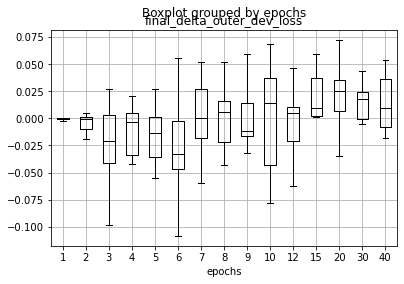

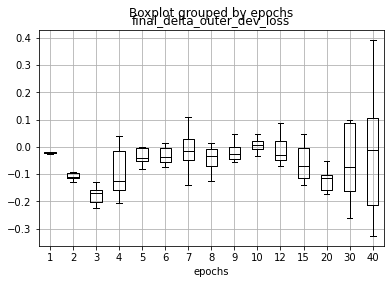

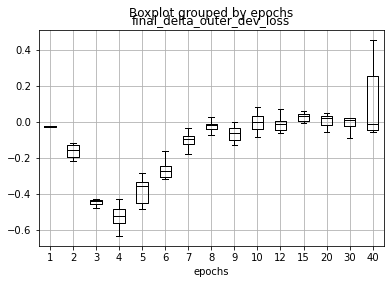

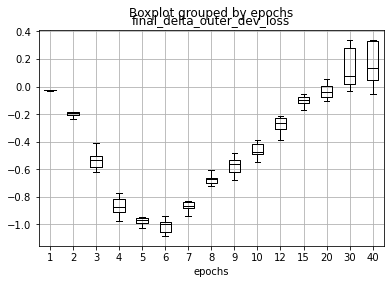

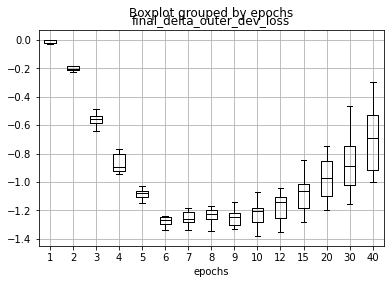

In [750]:
for regweight in regweight_list:
    df_main.loc[(df_main['grad_clip_val_outer']==0.5) & (df_main['regweight_rescaler']==1.05) & (df_main["regweight_init"]==regweight)].boxplot(column="final_delta_outer_dev_loss", by="epochs", showfliers=False, color="k")
    plt.show()

# for clip_val in clip_val_list:
#     df_main.loc[(df_main['grad_clip_val_outer']==clip_val) & (df_main['regweight_rescaler']==1.05) & (df_main["regweight_init"]==0.015)].boxplot(column="final_delta_outer_dev_loss", by="epochs", showfliers=False, color="k")
#     plt.show()

# for rescale in rescale_list:
#     df_main.loc[(df_main['grad_clip_val_outer']==clip_val) & (df_main['regweight_rescaler']==1.05) & (df_main["regweight_init"]==0.015)].boxplot(column="final_delta_outer_dev_loss", by="epochs", showfliers=False, color="k")
#     plt.show()

Choice of values to plot: 

['epochs' 'regweight_rescaler' 'regweight_init'
 "('delta_dev_is_negative', 'mean', 0.5)"
 "('delta_dev_is_negative', 'mean', 99999999999.0)"
 "('final_delta_outer_dev_loss', 'len', 0.5)"
 "('final_delta_outer_dev_loss', 'len', 99999999999.0)"
 "('final_delta_outer_dev_loss', 'mean', 0.5)"
 "('final_delta_outer_dev_loss', 'mean', 99999999999.0)"
 "('final_delta_outer_dev_loss', 'std', 0.5)"
 "('final_delta_outer_dev_loss', 'std', 99999999999.0)"]



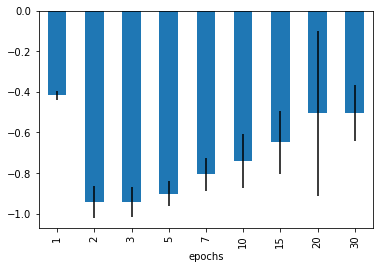

In [734]:
df_records = pd.DataFrame(df_pivot.to_records())
cols = df_records.columns.values
print(f"Choice of values to plot: \n\n{cols}\n")
df_records = df_records.loc[df_records["regweight_rescaler"]==1.05]
# df_records = df_records.loc[df_records["epochs"]==20]
# df_records = df_records.loc[df_records["regweight_init"]==0.01]
df_records

df_records.plot(x="epochs", 
                y="('final_delta_outer_dev_loss', 'mean', 0.5)", 
                yerr="('final_delta_outer_dev_loss', 'std', 0.5)", 
                kind="bar", 
                legend=None)

plt.show()

In [562]:
df_pivot = df_main.pivot_table(index=["epochs", "regweight_rescaler"], 
                    columns='grad_clip_val_outer', 
                    values=["final_delta_outer_dev_loss", "delta_dev_is_negative"], 
                    aggfunc={"final_delta_outer_dev_loss": [np.mean, np.std, len], "delta_dev_is_negative": [np.mean]})
print_full(df_pivot)

delta_dev_is_negative                      final_delta_outer_dev_loss                                                                                                         
                                           mean                                             len                                      mean                                       std                     
grad_clip_val_outer                       0.500   99,999,999,999.000                      0.500   99,999,999,999.000                0.500   99,999,999,999.000                0.500   99,999,999,999.000
epochs regweight_rescaler                                                                                                                                                                               
1      1.000                              1.000                1.000                     10.000               10.000               -0.419               -0.341                0.045                0.111
       1.050                              1.000                1.000                     10.000               10.000               -0.418               -0.368                0.021                0.055
2      1.000                              1.000                1.000                     10.000               10.000               -0.934               -0.867                0.077                0.110
       1.050                              1.000                1.000                     10.000               10.000               -0.943               -0.879                0.077                0.108
3      1.000                              1.000                1.000                     10.000               10.000               -0.946               -0.897                0.071                0.108
       1.050                              1.000                1.000                     10.000               10.000               -0.944               -0.869                0.072                0.125
5      1.000                              0.900                0.900                     10.000               10.000               -0.734               -0.686                0.474                0.475
       1.050                              1.000                1.000                     10.000               10.000               -0.902               -0.861                0.062                0.082
7      1.000                              0.900                0.700                     10.000               10.000               -0.651               -0.263                0.534                0.726
       1.050                              1.000                0.900                     10.000               10.000               -0.808               -0.624                0.079                0.333
10     1.000                              0.700                0.500                     10.000               10.000               -0.249                0.086                0.800                0.880
       1.050                              1.000                0.900                     10.000               10.000               -0.741               -0.588                0.131                0.319
15     1.000                              0.800                0.800                     10.000               10.000               -0.334               -0.249                0.722                0.616
       1.050                              1.000                0.900                     10.000               10.000               -0.650               -0.442                0.153                0.421
20     1.000                              0.500                0.500                     10.000               10.000                0.216                0.205                0.863                0.941
       1.050                              0.900                1.000                     10.000               10.000               -0.507               -0.551                0.408                0.212
30    

In [764]:
df_pivot = df_main.pivot_table(index=["epochs"], 
                    columns='grad_clip_val_outer', 
                    values=["final_delta_outer_dev_loss", "delta_dev_is_negative"], 
                    aggfunc={"final_delta_outer_dev_loss": [np.mean, np.std, len], "delta_dev_is_negative": [np.mean]})
print_full(df_pivot)

delta_dev_is_negative                                           final_delta_outer_dev_loss                                                                                                                                                                        
                                     mean                                                                  len                                                           mean                                                            std                                          
grad_clip_val_outer                 0.500                2.000   99,999,999,999.000                      0.500                2.000   99,999,999,999.000                0.500                2.000   99,999,999,999.000                0.500                2.000   99,999,999,999.000
epochs                                                                                                                                                                                                                                                                                
1                                   0.950                0.950                0.950                    100.000              100.000              100.000               -0.014               -0.014               -0.014                0.012                0.012                0.012
2                                   0.900                0.880                0.840                    100.000              100.000              100.000               -0.134               -0.125               -0.105                0.078                0.073                0.074
3                                   0.910                0.920                0.880                    100.000              100.000              100.000               -0.342               -0.323               -0.287                0.218                0.209                0.204
4                                   0.860                0.900                0.930                    100.000              100.000              100.000               -0.466               -0.460               -0.436                0.367                0.348                0.351
5                                   0.910                0.890                0.830                    100.000              100.000              100.000               -0.490               -0.480               -0.456                0.457                0.444                0.456
6                                   0.890                0.850                0.780                    100.000              100.000              100.000               -0.503               -0.491               -0.463                0.518                0.511                0.506
7                                   0.820                0.840                0.800                    100.000              100.000              100.000               -0.438               -0.433               -0.427                0.517                0.512                0.521
8                                   0.760                0.730                0.780                    100.000              100.000              100.000               -0.396               -0.377               -0.363                0.496                0.493                0.479
9                                   0.830                0.788                0.770                    100.000               99.000              100.000               -0.375               -0.365               -0.338                0.486                0.484                0.491
10                                  0.680                0.750                0.700                    100.000              100.000              100.000               -0.338               -0.330               -0.319                0.486                0.472                0.459
12                                  0.750                0.700                0.710                    100.000    

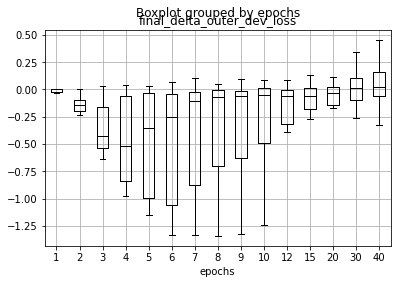

In [765]:
df_main.loc[(df_main['grad_clip_val_outer']==0.5)].boxplot(column="final_delta_outer_dev_loss", by="epochs", showfliers=False, color="k")
plt.show()

Choice of values to plot: 

['epochs' "('delta_dev_is_negative', 'mean', 0.5)"
 "('delta_dev_is_negative', 'mean', 2.0)"
 "('delta_dev_is_negative', 'mean', 99999999999.0)"
 "('final_delta_outer_dev_loss', 'len', 0.5)"
 "('final_delta_outer_dev_loss', 'len', 2.0)"
 "('final_delta_outer_dev_loss', 'len', 99999999999.0)"
 "('final_delta_outer_dev_loss', 'mean', 0.5)"
 "('final_delta_outer_dev_loss', 'mean', 2.0)"
 "('final_delta_outer_dev_loss', 'mean', 99999999999.0)"
 "('final_delta_outer_dev_loss', 'std', 0.5)"
 "('final_delta_outer_dev_loss', 'std', 2.0)"
 "('final_delta_outer_dev_loss', 'std', 99999999999.0)"]



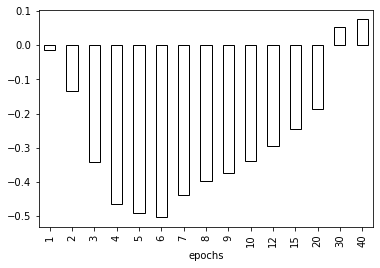

In [766]:
df_records = pd.DataFrame(df_pivot.to_records())
cols = df_records.columns.values
print(f"Choice of values to plot: \n\n{cols}\n")

df_records.plot(x="epochs", y="('final_delta_outer_dev_loss', 'mean', 0.5)", kind="bar", legend=None, color="w", edgecolor="k")
plt.show()

In [538]:
df_pivot = df_main.pivot_table(index=["grad_clip_val_outer", "regweight_rescaler"], 
                    values=["final_delta_outer_dev_loss", "delta_dev_is_negative"], 
                    aggfunc={"final_delta_outer_dev_loss": [np.mean, np.std, len], "delta_dev_is_negative": [np.mean]})
print_full(df_pivot)

delta_dev_is_negative final_delta_outer_dev_loss                                          
                                                        mean                        len                 mean                  std
grad_clip_val_outer regweight_rescaler                                                                                           
             0.500  1.000                              0.789                     90.000               -0.384                0.738
                    1.050                              0.989                     90.000               -0.713                0.249
99,999,999,999.000  1.000                              0.744                     90.000               -0.267                0.755
                    1.050                              0.944                     90.000               -0.612                0.322

In [762]:
df_pivot = df_main.pivot_table(index=["grad_clip_val_outer"], 
                    values=["final_delta_outer_dev_loss", "delta_dev_is_negative"], 
                    aggfunc={"final_delta_outer_dev_loss": [np.mean, np.std, len], "delta_dev_is_negative": [np.mean]})
print_full(df_pivot)

delta_dev_is_negative final_delta_outer_dev_loss                                          
                                     mean                        len                 mean                  std
grad_clip_val_outer                                                                                           
             0.500                  0.759                  1,499.000               -0.273                0.474
             2.000                  0.768                  1,499.000               -0.269                0.456
99,999,999,999.000                  0.732                  1,499.000               -0.233                0.477

Choice of values to plot: 

['grad_clip_val_outer' "('delta_dev_is_negative', 'mean')"
 "('final_delta_outer_dev_loss', 'len')"
 "('final_delta_outer_dev_loss', 'mean')"
 "('final_delta_outer_dev_loss', 'std')"]



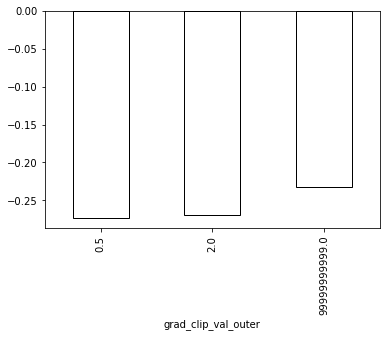

In [763]:
df_records = pd.DataFrame(df_pivot.to_records())
cols = df_records.columns.values
print(f"Choice of values to plot: \n\n{cols}\n")

df_records.plot(x='grad_clip_val_outer', y="('final_delta_outer_dev_loss', 'mean')", kind="bar", legend=None, color="w", edgecolor="k")
plt.show()

In [510]:
df_pivot = df_main.pivot_table(index=["regweight_rescaler"], 
                    values=["final_delta_outer_dev_loss", "delta_dev_is_negative"], 
                    aggfunc={"final_delta_outer_dev_loss": [np.mean, np.std, len], "delta_dev_is_negative": [np.mean]})
print_full(df_pivot)

delta_dev_is_negative final_delta_outer_dev_loss                                          
                                    mean                        len                 mean                  std
regweight_rescaler                                                                                           
1.000                              0.767                    180.000               -0.326                0.747
1.050                              0.967                    180.000               -0.662                0.291

In [759]:
df_pivot = df_main.pivot_table(index=["regweight_init"], 
                    values=["final_delta_outer_dev_loss", "delta_dev_is_negative"], 
                    aggfunc={"final_delta_outer_dev_loss": [np.mean, np.std, len], "delta_dev_is_negative": [np.mean]})
print_full(df_pivot)

delta_dev_is_negative final_delta_outer_dev_loss                                          
                                mean                        len                 mean                  std
regweight_init                                                                                           
0.000                          0.481                    900.000                0.002                0.037
0.001                          0.744                    898.000               -0.045                0.152
0.005                          0.760                    899.000               -0.085                0.289
0.010                          0.860                    900.000               -0.361                0.514
0.015                          0.921                    900.000               -0.802                0.529

Choice of values to plot: 

['regweight_init' "('delta_dev_is_negative', 'mean')"
 "('final_delta_outer_dev_loss', 'len')"
 "('final_delta_outer_dev_loss', 'mean')"
 "('final_delta_outer_dev_loss', 'std')"]



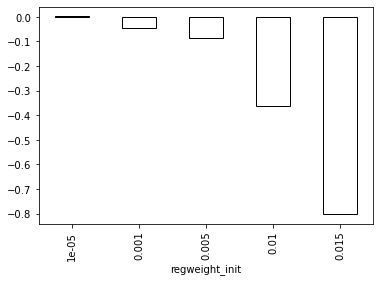

In [760]:
df_records = pd.DataFrame(df_pivot.to_records())
cols = df_records.columns.values
print(f"Choice of values to plot: \n\n{cols}\n")

df_records.plot(x='regweight_init', y="('final_delta_outer_dev_loss', 'mean')", kind="bar", legend=None, color="w", edgecolor="k")
plt.show()

# Plots

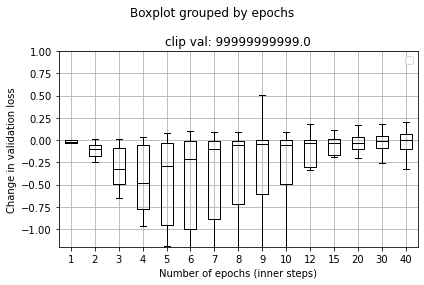

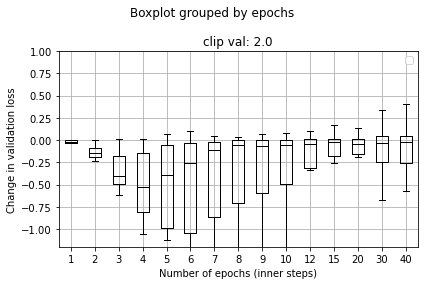

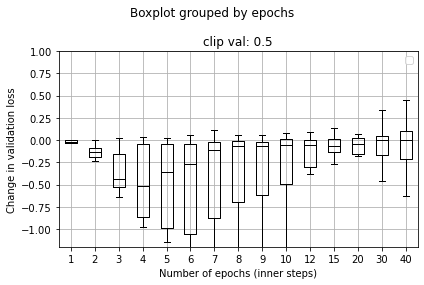

In [707]:
# Separate plots for each clip value

for clip_val in clip_val_list:
    df_temp = df_main.loc[df_main["grad_clip_val_outer"]==clip_val, ["epochs", "final_delta_outer_dev_loss"]]
#     df_temp.groupby(['epochs']).mean().plot.bar(color='w', edgecolor="k", yerr=df_temp.groupby(['epochs']).std())
    df_temp.boxplot(column="final_delta_outer_dev_loss", by="epochs", showfliers=False, color="k")
    plt.ylabel("Change in validation loss")
    plt.xlabel("Number of epochs (inner steps)")
    plt.ylim([-1.2,1.0])
    plt.legend("")
    plt.title(f"clip val: {clip_val}")
    plt.tight_layout()

# TAG

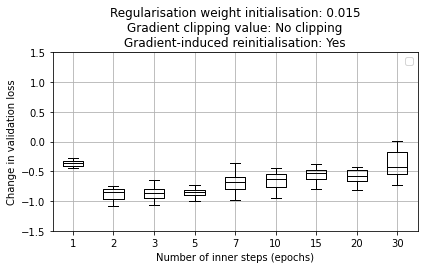

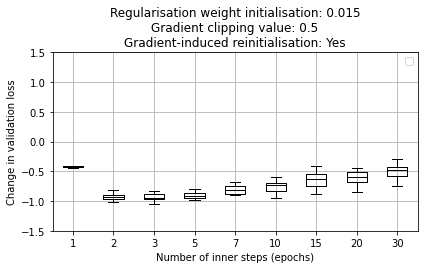

In [7]:
# separate plots for each clip value and initial regularisation weight

clip_val_list = [99999999999, 0.5]

for clip_val in clip_val_list:
    for regweight in regweight_list:
        df_temp = df_main.loc[df_main["grad_clip_val_outer"]==clip_val, ["regweight_init","epochs", "final_delta_outer_dev_loss"]]
        df_temp = df_temp.loc[df_temp["regweight_init"]==regweight, ["epochs", "final_delta_outer_dev_loss"]]
#         df_temp.groupby(['epochs']).mean().plot.bar(color='w', edgecolor="k", yerr=df_temp.groupby(['epochs']).std())
        df_temp.boxplot(column="final_delta_outer_dev_loss", by="epochs", showfliers=False, color="k")
        plt.ylabel("Change in validation loss")
        plt.xlabel("Number of inner steps (epochs)")
        plt.ylim([-1.5,1.5])
        plt.legend("")
        plt.suptitle("")
#         if clip_val == 0.5:
#             plt.title(f"Validation loss against number of inner steps\nGradient clipping value: 0.5\nRegularisation weight initialisation: {regweight}", weight="bold")
#         else:
#             plt.title(f"Validation loss against number of inner steps\nRelationship between number of inner steps and change in validation loss\nGradient clipping value: No clipping\nRegularisation weight initialisation: {regweight}", weight="bold")
        if clip_val == 0.5:
            plt.title(f"Regularisation weight initialisation: {regweight}\nGradient clipping value: 0.5\nGradient-induced reinitialisation: Yes")
        else:
            plt.title(f"Regularisation weight initialisation: {regweight}\nGradient clipping value: No clipping\nGradient-induced reinitialisation: Yes")
        plt.tight_layout()
        plt.savefig(f"../realmeta_nations/plots/realmeta_deltavalidloss_byepoch_clipping{clip_val}_reginit{regweight}_withrescale.png")

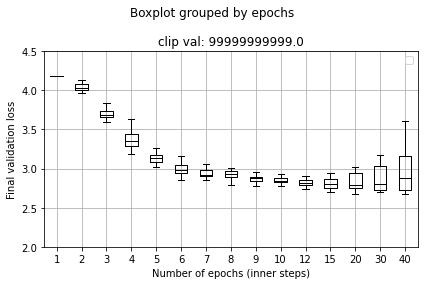

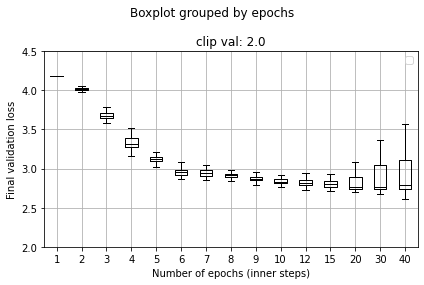

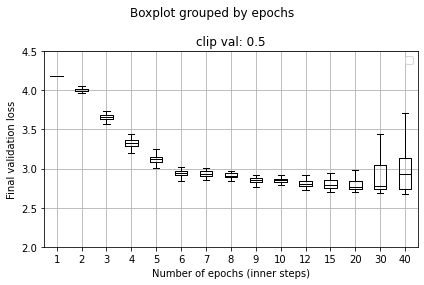

In [702]:
# Separate plots for each clip value

for clip_val in clip_val_list:
    df_temp = df_main.loc[df_main["grad_clip_val_outer"]==clip_val, ["epochs", "final_dev_loss_outer"]]
#     df_temp.groupby(['epochs']).mean().plot.bar(color='w', edgecolor="k", yerr=df_temp.groupby(['epochs']).std())
    df_temp.boxplot(column="final_dev_loss_outer", by="epochs", showfliers=False, color="k")
    plt.ylabel("Final validation loss")
    plt.xlabel("Number of epochs (inner steps)")
    plt.ylim([2.0,4.5])
    plt.legend("")
    plt.title(f"clip val: {clip_val}")
    plt.tight_layout()

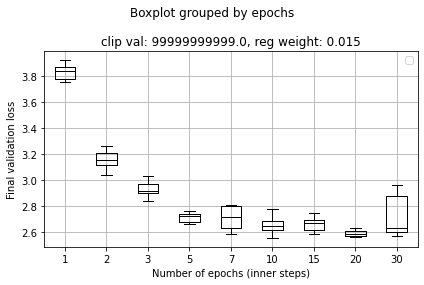

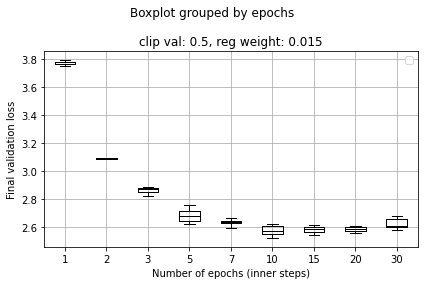

In [6]:
for clip_val in clip_val_list:
    for regweight in regweight_list:
        df_temp = df_main.loc[df_main["grad_clip_val_outer"]==clip_val, ["regweight_init","epochs", "final_dev_loss_outer"]]
        df_temp = df_temp.loc[df_temp["regweight_init"]==regweight, ["epochs", "final_dev_loss_outer"]]
#         df_temp.groupby(['epochs']).mean().plot.bar(color='w', edgecolor="k", yerr=df_temp.groupby(['epochs']).std())
        df_temp.boxplot(column="final_dev_loss_outer", by="epochs", showfliers=False, color="k")
        plt.ylabel("Final validation loss")
        plt.xlabel("Number of epochs (inner steps)")
#         plt.ylim([2.0,4.0])
        plt.legend("")
        plt.title(f"clip val: {clip_val}, reg weight: {regweight}")
        plt.tight_layout()

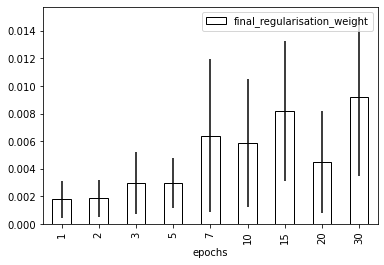

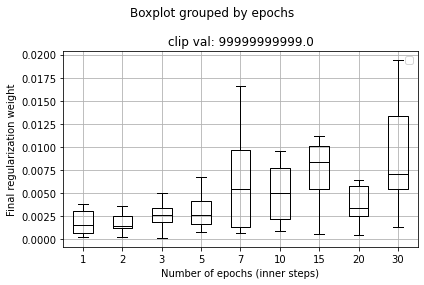

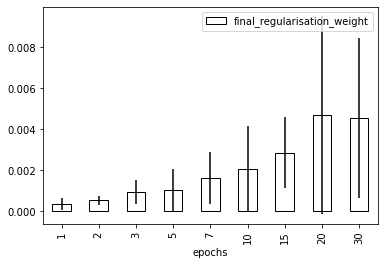

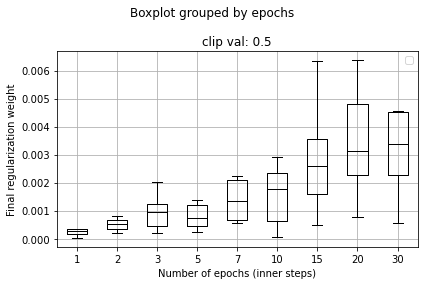

In [686]:
for clip_val in clip_val_list:
    df_temp = df_main.loc[df_main["grad_clip_val_outer"]==clip_val, ["epochs", "final_regularisation_weight"]]
    df_temp.groupby(['epochs']).mean().plot.bar(color='w', edgecolor="k", yerr=df_temp.groupby(['epochs']).std())
    df_temp.boxplot(column="final_regularisation_weight", by="epochs", showfliers=False, color="k")
    plt.ylabel("Final regularization weight")
    plt.xlabel("Number of epochs (inner steps)")
    plt.legend("")
    plt.title(f"clip val: {clip_val}")
    plt.tight_layout()

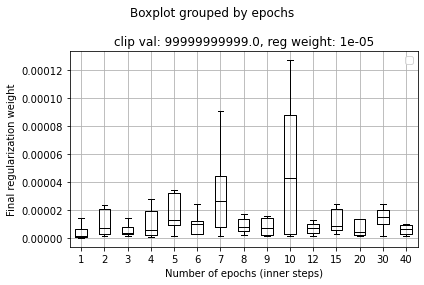

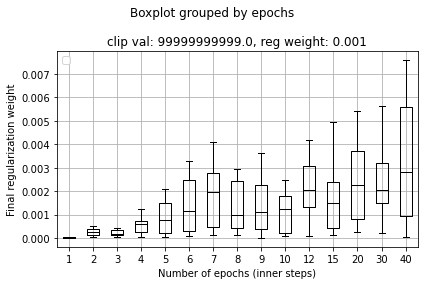

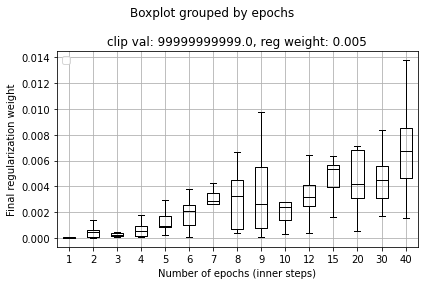

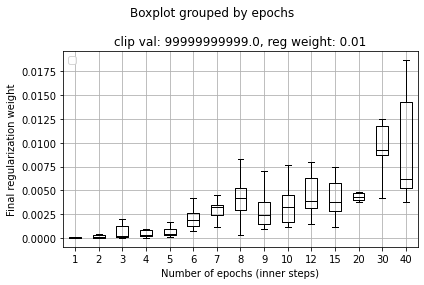

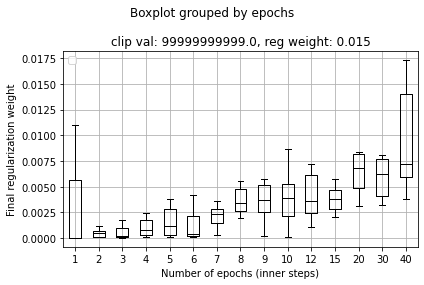

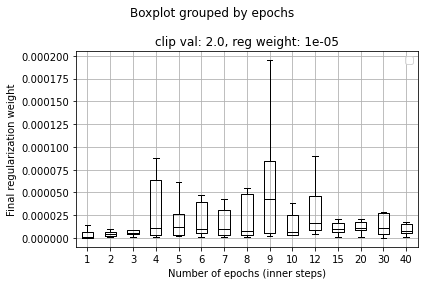

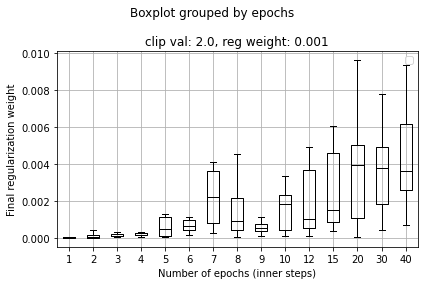

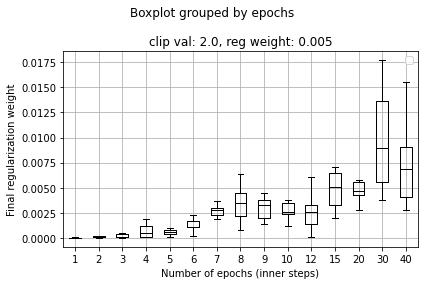

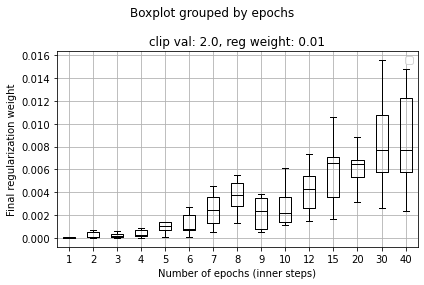

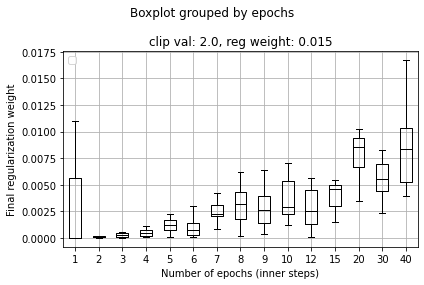

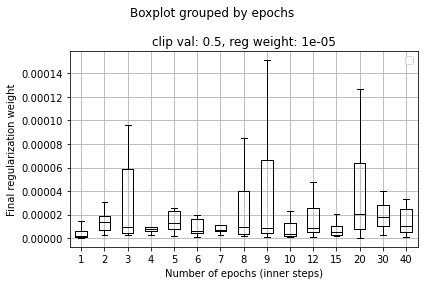

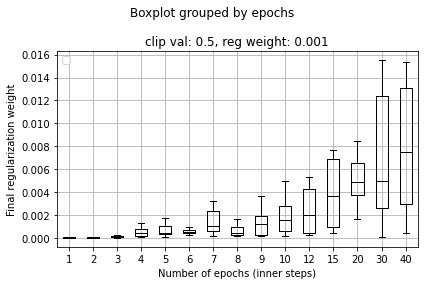

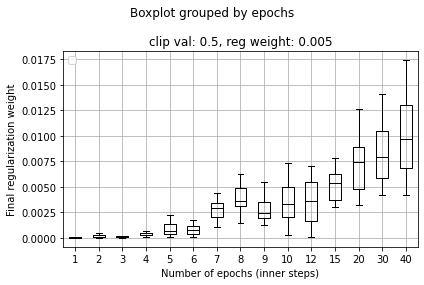

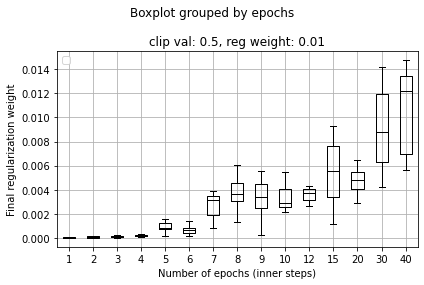

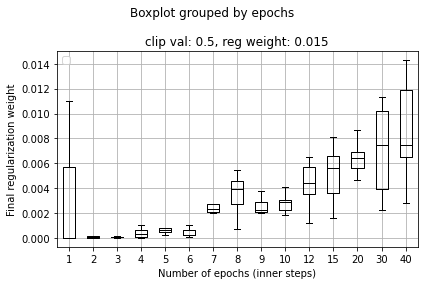

In [699]:
for clip_val in clip_val_list:
    for regweight in regweight_list:
        df_temp = df_main.loc[df_main["grad_clip_val_outer"]==clip_val, ["regweight_init","epochs", "final_regularisation_weight"]]
        df_temp = df_temp.loc[df_temp["regweight_init"]==regweight, ["epochs", "final_regularisation_weight"]]
#         df_temp.groupby(['epochs']).mean().plot.bar(color='w', edgecolor="k", yerr=df_temp.groupby(['epochs']).std())
        df_temp.boxplot(column="final_regularisation_weight", by="epochs", showfliers=False, color="k")
        plt.ylabel("Final regularization weight")
        plt.xlabel("Number of epochs (inner steps)")
        plt.legend("")
        plt.title(f"clip val: {clip_val}, reg weight: {regweight}")
        plt.tight_layout()

In [72]:
for clip_val in clip_val_list:
    df_temp = df_main.loc[df_main["grad_clip_val_outer"]==clip_val, ["regweight_init", "final_regularisation_weight"]]
    df_temp.groupby(["regweight_init"]).mean().plot.bar(color='w', edgecolor="k", yerr=df_temp.groupby(['epochs']).std())
    plt.ylabel("Final regularization weight")
    plt.xlabel("Initial regularization weight")
    plt.legend("")
    plt.title(f"clip val: {clip_val}")
    plt.tight_layout()

NameError: name 'clip_val_list' is not defined

In [601]:


for clip_val in clip_val_list:
    for epochs in epochs_list:
        df_temp = df_main.loc[df_main["grad_clip_val_outer"]==clip_val, ["regweight_init","epochs", "final_regularisation_weight"]]
        df_temp = df_temp.loc[df_temp["epochs"]==epochs, ["regweight_init", "final_regularisation_weight"]]
        df_temp.groupby(["regweight_init"]).mean().plot.bar(color='w', edgecolor="k", yerr=df_temp.groupby(['epochs']).std())
        plt.ylabel("Final regularization weight")
        plt.xlabel("Initial regularization weight")
        plt.legend("")
        plt.title(f"clip val: {clip_val}, number of epochs: {epochs}")
        plt.tight_layout()

KeyError: 'epochs'

# Baselines

In [17]:
# mini batch setting
df_main = pd.read_csv('single_grid_minibatch_gradcliprescaling_nations_v2.csv')
# df_main = pd.read_csv('single_grid_fullbatch_gradcliprescaling_nations.csv')
df_main = df_main.round({"regweight_init": 6})
epochs_list = list(df_main["epochs"].unique())
regweight_list = list(df_main["regweight_init"].unique())

print(epochs_list)
print(regweight_list)

df_pivot = df_main.pivot_table(index=["epochs"], 
                    columns="regweight_init", 
                    values=["final_dev_loss_inner"], 
                    aggfunc={"final_dev_loss_inner": [np.median, np.max, np.min]})

s_idx = df_pivot["final_dev_loss_inner"]["median"].idxmin(axis=1)
s_mins =df_pivot["final_dev_loss_inner"]["median"].min(axis=1)
results_df = pd.DataFrame()
for i, epochs in enumerate(epochs_list):
    best_regweight = s_idx.loc[epochs]
    med_mid = s_mins.loc[epochs]
    med_max = df_pivot["final_dev_loss_inner"]["amax"].loc[epochs].loc[s_idx.to_numpy()[i]]
    med_min = df_pivot["final_dev_loss_inner"]["amin"].loc[epochs].loc[s_idx.to_numpy()[i]]
    results_df = results_df.append({"epochs": epochs, "best reg weight": best_regweight, "median": med_mid, "min": med_min, "max": med_max}, ignore_index=True)
# pd.DataFrame([s_idx, df_med_mid, df_med_min, df_med_max]).transpose()
results_df

TOL = 0.05 # how much does median dev loss have to differ to min median dev loss to be considered part of plateau

# convert results to boolean 
df_np_full = df_pivot["final_dev_loss_inner"]["median"].to_numpy()
df_np_mins = s_mins.to_numpy()[:,np.newaxis]
boolean_array = df_np_full<df_np_mins+TOL

# range of values for which median dev loss is within the specified value of the minimum median

for row in range(boolean_array.shape[0]):
    true_idx = np.where(boolean_array[row]==True)[0]
    
    print(f"Epochs {epochs_list[row]}, plateau min {regweight_list[true_idx[0]]}, plateau max {regweight_list[true_idx[-1]]}")

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30]
[0.0, 1e-05, 0.0001, 0.0005, 0.001, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022]
Epochs 1, plateau min 0.0, plateau max 0.001
Epochs 2, plateau min 0.0001, plateau max 0.001
Epochs 3, plateau min 0.0001, plateau max 0.002
Epochs 4, plateau min 0.0, plateau max 0.002
Epochs 5, plateau min 0.0, plateau max 0.002
Epochs 6, plateau min 0.0, plateau max 0.002
Epochs 7, plateau min 0.0, plateau max 0.002
Epochs 8, plateau min 0.0, plateau max 0.002
Epochs 9, plateau min 0.0, plateau max 0.002
Epochs 10, plateau min 0.0, plateau max 0.004
Epochs 12, plateau min 0.0, plateau max 0.004
Epochs 15, plateau min 0.0, plateau max 0.004
Epochs 20, plateau min 0.0001, plateau max 0.006
Epochs 30, plateau min 0.0001, plateau max 0.006


In [16]:
# mini batch setting
# df_main = pd.read_csv('single_grid_minibatch_gradcliprescaling_nations_v2.csv')
df_main = pd.read_csv('single_grid_fullbatch_gradcliprescaling_nations.csv')
df_main = df_main.round({"regweight_init": 6})
epochs_list = list(df_main["epochs"].unique())
regweight_list = list(df_main["regweight_init"].unique())

In [18]:
print(epochs_list)
print(regweight_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30]
[0.0, 1e-05, 0.0001, 0.0005, 0.001, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022]


In [19]:
df_pivot = df_main.pivot_table(index=["epochs"], 
                    columns="regweight_init", 
                    values=["final_dev_loss_inner"], 
                    aggfunc={"final_dev_loss_inner": [np.median, np.max, np.min]})
# print_full(df_pivot)
df_pivot

final_dev_loss_inner                                          \
                               amax                                           
regweight_init              0.00000   0.00001   0.00010   0.00050   0.00100   
epochs                                                                        
1                          3.879542  3.875808  3.847222  3.837953  3.857679   
2                          3.259181  3.257982  3.190036  3.152893  3.183566   
3                          2.957392  2.969164  2.880749  2.873778  2.868008   
4                          2.839002  2.834308  2.775836  2.764883  2.747162   
5                          2.752906  2.748503  2.717844  2.716507  2.693012   
6                          2.717038  2.716379  2.679297  2.672853  2.657300   
7                          2.687258  2.689997  2.664811  2.653360  2.625296   
8                          2.665543  2.672298  2.657657  2.647342  2.604097   
9                          2.655413  2.663211  2.636760  2.631544  2.595222   
10                         2.643191  2.650557  2.631732  2.625637  2.587091   
12                         2.644895  2.652767  2.626480  2.622294  2.587660   
15                         2.637812  2.646864  2.627992  2.627697  2.584132   
20                         2.660594  2.655265  2.629307  2.629215  2.594726   
30                         2.699436  2.691214  2.669033  2.667307  2.620555   

                                                                  ...  \
                                                                  ...   
regweight_init   0.00200   0.00400   0.00600   0.00800   0.01000  ...   
epochs                                                            ...   
1               3.921028  4.009326  4.053775  4.107510  4.157858  ...   
2               3.259856  3.324489  3.432920  3.564440  3.745160  ...   
3               2.954030  3.005390  3.084497  3.194596  3.418837  ...   
4               2.799861  2.852855  2.928707  3.006533  3.187483  ...   
5               2.717178  2.772281  2.840742  2.908860  3.066767  ...   
6               2.677235  2.717927  2.782123  2.845279  2.974669  ...   
7               2.637772  2.683442  2.744139  2.802504  2.902545  ...   
8               2.625248  2.663344  2.720315  2.771073  2.854570  ...   
9               2.610179  2.648356  2.697786  2.752991  2.817891  ...   
10              2.604418  2.637659  2.685399  2.737198  2.787649  ...   
12              2.591795  2.627498  2.657215  2.716236  2.753627  ...   
15              2.599231  2.621087  2.637442  2.703168  2.726415  ...   
20              2.602090  2.616531  2.621250  2.678711  2.698475  ...   
30              2.619857  2.616128  2.618646  2.666173  2.679519  ...   

                                                                            \
                  median                                                     
regweight_init   0.00400   0.00600   0.00800   0.01000   0.01200   0.01400   
epochs                                                                       
1               3.930301  3.987324  4.052897  4.116825  4.160745  4.189381   
2               3.281276  3.394130  3.517333  3.648855  3.810432  3.957494   
3               2.957878  3.038894  3.152879  3.284578  3.514301  3.723971   
4               2.807062  2.882891  2.956928  3.051759  3.294909  3.577987   
5               2.732772  2.802876  2.867135  2.942799  3.145698  3.458441   
6               2.694125  2.746580  2.816042  2.862045  3.047660  3.357758   
7               2.660313  2.708076  2.777217  2.812827  2.988179  3.283642   
8               2.636085  2.689107  2.750849  2.781870  2.933696  3.219698   
9               2.621310  2.667278  2.732006  2.760701  2.896288  3.166969   
10              2.610573  2.651285  2.713709  2.740128  2.866464  3.124668   
12              2.594922  2.633831  2.682337  2.713130  2.828018  3.071969   
15              2.587962  2.620507  2.662876  2.687183  2.794769  3.012525   
20              2.576942  2.6

In [20]:
s_idx = df_pivot["final_dev_loss_inner"]["median"].idxmin(axis=1)
s_mins =df_pivot["final_dev_loss_inner"]["median"].min(axis=1)
results_df = pd.DataFrame()
for i, epochs in enumerate(epochs_list):
    best_regweight = s_idx.loc[epochs]
    med_mid = s_mins.loc[epochs]
    med_max = df_pivot["final_dev_loss_inner"]["amax"].loc[epochs].loc[s_idx.to_numpy()[i]]
    med_min = df_pivot["final_dev_loss_inner"]["amin"].loc[epochs].loc[s_idx.to_numpy()[i]]
    results_df = results_df.append({"epochs": epochs, "best reg weight": best_regweight, "median": med_mid, "min": med_min, "max": med_max}, ignore_index=True)
# pd.DataFrame([s_idx, df_med_mid, df_med_min, df_med_max]).transpose()
results_df

,best reg weight,epochs,max,median,min
0,0.0005,1.0,3.837953,3.761782,3.693868
1,0.0005,2.0,3.152893,3.098520,3.069013
2,0.0005,3.0,2.873778,2.831066,2.785749
3,0.0010,4.0,2.747162,2.715242,2.672044
4,0.0001,5.0,2.717844,2.655935,2.608901
5,0.0001,6.0,2.679297,2.614475,2.568099
6,0.0001,7.0,2.664811,2.595358,2.562923
7,0.0001,8.0,2.657657,2.572858,2.545774
8,0.0001,9.0,2.636760,2.564499,2.541780
9,0.0001,10.0,2.631732,2.560912,2.540725


In [21]:
# df_pivot["final_dev_loss_inner"]["amin"].iloc[[1,2],[1,2]]
# df_pivot["final_dev_loss_inner"]["amin"].to_numpy()[[1,2],[1,2]]

In [22]:
TOL = 0.05 # how much does median dev loss have to differ to min median dev loss to be considered part of plateau

# convert results to boolean 
df_np_full = df_pivot["final_dev_loss_inner"]["median"].to_numpy()
df_np_mins = s_mins.to_numpy()[:,np.newaxis]
boolean_array = df_np_full<df_np_mins+TOL

# range of values for which median dev loss is within the specified value of the minimum median

for row in range(boolean_array.shape[0]):
    true_idx = np.where(boolean_array[row]==True)[0]
    
    print(f"Epochs {epochs_list[row]}, plateau min {regweight_list[true_idx[0]]}, plateau max {regweight_list[true_idx[-1]]}")

Epochs 1, plateau min 0.0, plateau max 0.001
Epochs 2, plateau min 0.0001, plateau max 0.001
Epochs 3, plateau min 0.0001, plateau max 0.002
Epochs 4, plateau min 0.0, plateau max 0.002
Epochs 5, plateau min 0.0, plateau max 0.002
Epochs 6, plateau min 0.0, plateau max 0.002
Epochs 7, plateau min 0.0, plateau max 0.002
Epochs 8, plateau min 0.0, plateau max 0.002
Epochs 9, plateau min 0.0, plateau max 0.002
Epochs 10, plateau min 0.0, plateau max 0.004
Epochs 12, plateau min 0.0, plateau max 0.004
Epochs 15, plateau min 0.0, plateau max 0.004
Epochs 20, plateau min 0.0001, plateau max 0.006
Epochs 30, plateau min 0.0001, plateau max 0.006


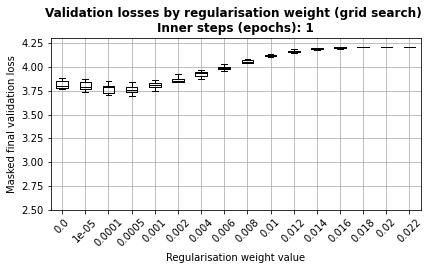

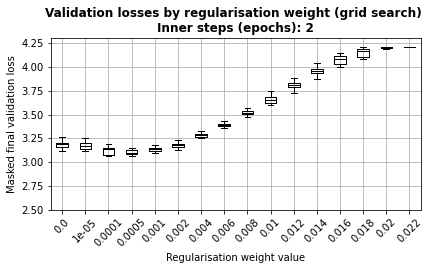

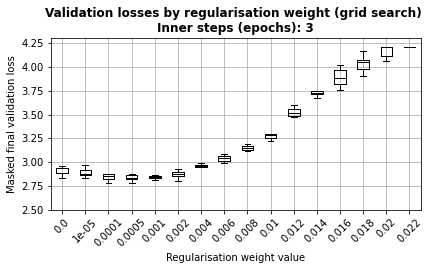

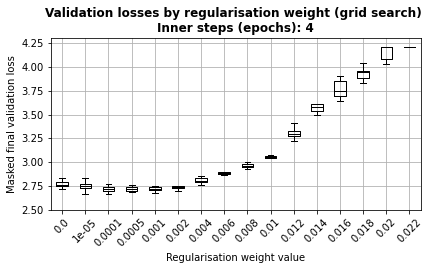

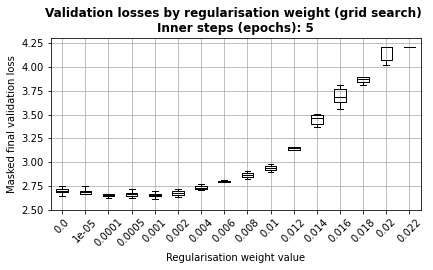

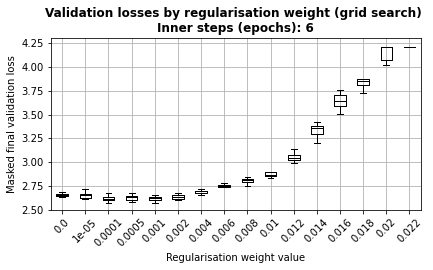

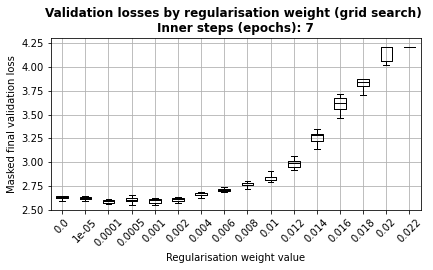

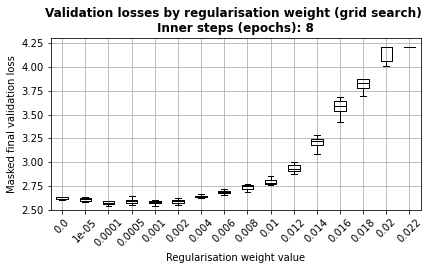

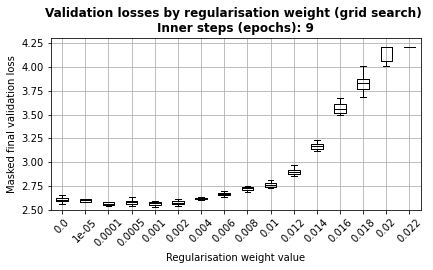

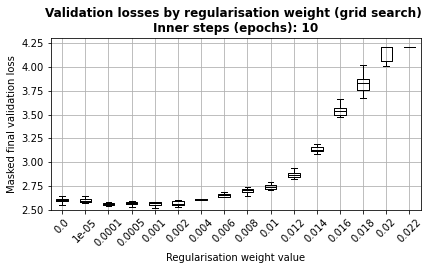

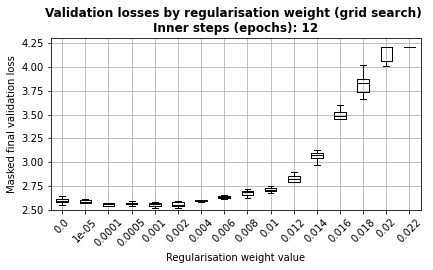

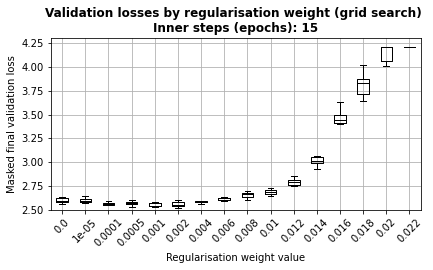

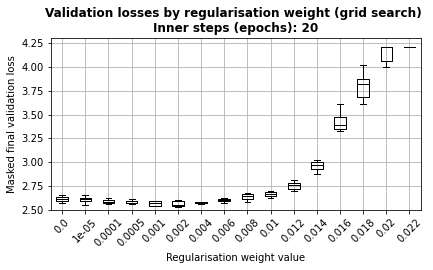

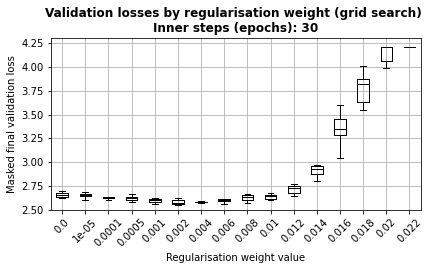

In [25]:
for epochs in epochs_list:
    df_temp = df_main
    df_temp = df_temp.loc[df_temp["epochs"]==epochs, ["regweight_init", "final_dev_loss_inner"]]
    plot = df_temp.boxplot(column="final_dev_loss_inner", by="regweight_init", showfliers=False, color="k")
    plt.suptitle('')
    plt.xticks(rotation=45)
    plt.xlabel("Regularisation weight value")
    plt.ylabel("Masked final validation loss")
    plt.ylim([2.5,4.3])
    plt.title(f"Validation losses by regularisation weight (grid search) \nInner steps (epochs): {epochs}", weight="bold")
    plt.tight_layout()
    plt.savefig(f"../realmeta_nations/plots/grid_minibatch_epochs{epochs}", dpi=200)